# Assignment 1: Perceptron Learning

The goal of this exercise is to apply the perceptron learning to a total of $N=100$ automatically generated, separable random data $X=\bigl\{\vec x^1, \vec x^2,\ldots,\vec x^ N \bigr\}$ with each $\vec x^n = \bigl(x_1^n, x_2^n\bigr)^T$.
Each data point $\vec x^n$ is accompanied by an according target value $X=\bigl\{t^1, t^2,\ldots,t^ N\bigr\}$ with $t^n \in \{-1,+1\}$.

## Data Generation
The data should be generated such that
$\forall n\leq\frac N2\colon \vec x^n \sim \mathcal N_{\vec\mu_+, \sigma_+}$.
These samples will be our positive data labeled with $t^n=1$.
Similarly, we generate our negative data with
$\forall n>\frac N2\colon \vec x^n \sim \mathcal N_{\vec\mu_-, \sigma_-}$
and label them as $t^n=-1$.


### Task 1: Data Samples

Given the number of samples and the means (mu) and standard deviations (sigma) of positive (pos) and negative (neg) data, generate and return data samples including their labels. Remember to add the bias neuron $x_0=1$ to each of the samples.

Hints:
1. Use `numpy` package to generate data.
2. Exemplary means could be selected as: $\vec\mu_+=(-5,3)^T$ and $\vec\mu_- = (5, -3)^T$. The standard deviations $\sigma_+$ and $\sigma_-$ should be selected such that the data is most likely separable.

In [ ]:
import numpy

def dataset(number_of_samples, mu_pos, sigma_pos, mu_neg, sigma_neg):
  # create positive and negative data
  positive_data = numpy.random.normal(mu_pos, sigma_pos, (number_of_samples//2, 2)) # numpy.random.normal generates distributed data with the specified means, std and output shape
  negative_data = numpy.random.normal(mu_neg, sigma_neg, (number_of_samples//2, 2))

  # assign positive and negative labels
  positive_labels = numpy.ones(int(number_of_samples/2))
  negative_labels = (-1) * numpy.ones(int(number_of_samples/2))

  # concatenate positive and negative data
  all_data = numpy.concatenate((positive_data, negative_data))
  all_labels = numpy.concatenate((positive_labels, negative_labels))

  # anything else to consider?
  ### Adding the bias neuron 1 as x0 so at the first entry
  all_data = numpy.insert(all_data, 0, numpy.ones(number_of_samples), axis=1)

  # return both X and T
  return all_data, all_labels

### Task 2: Select Data Parameters and Line Parameters

We want to select data points such that we exactly know where the ideal separating line should be placed.
Note that data samples are not always separable since they are generated randomly.
You should determine, which means and standard deviations are useful.

Once you have defined your means, you should also define the separating line.
The easiest is to provide it as Cartesian equation: $w_0 + w_1 x_1 + w_2 x_2$.
Note that the separating line is orthogonal to the vector $\overrightarrow{\vec\mu_- \vec\mu_+}$, that the normal of the line $(w_1, w_2)^T$ is orthogonal to the line, and that $w_0$ should be selected such that the line $\vec w$ is in the middle of $\vec\mu_+$ and $\vec\mu_-$.

In [ ]:
### Makes it easier to understand

import matplotlib.pyplot as plt

def plot_data(X, T, mu_pos, mu_neg):
  plt.figure(figsize=(5, 5))
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.scatter(X[:,1], X[:,2], c=T)
  plt.plot((mu_pos[0], mu_neg[0]), (mu_pos[1], mu_neg[1]))
  plt.ylim(-10, 10)
  plt.xlim(-10, 10)
  plt.show()

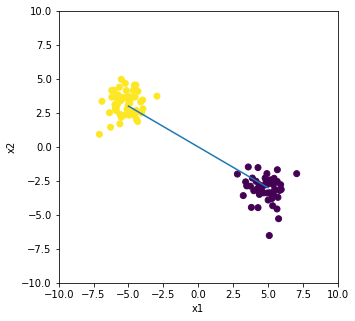

In [ ]:
mu_pos = (-5, 3)
mu_neg = (5, -3)
X, T = dataset(100, mu_pos, 1, mu_neg, 1)
plot_data(X, T, mu_pos, mu_neg)

# Calculation for w
mu_vec = numpy.subtract(mu_pos, mu_neg) # (-10, 6)
midpoint = ((mu_pos[0]+mu_neg[0])/2, ((mu_pos[0]+mu_neg[0])/2)) # (0, 0)
w = numpy.array([midpoint[1], -midpoint[0]]) # (0, 0)

w_manual = numpy.array([0.0, -5.0, 3.0])

Test 1: Linear Separability Test
A line $a = f_{\vec w}(\vec x) = w_0 + w_1 x_1 + w_2 x_2$ linearly separates the data $(X,T)$ if $\forall n: a^{[n]} t^{[n]} > 0$ for $a^{[n]} = f_{\vec w}(\vec x^{[n]})$.
The below function implements this linear separability test. We apply this test to your data $(X,T)$ from Task 1 and your manually selected line $\vec w$ from Task 2 to assure that the line separates the data.

In [ ]:
def separability_test(X, T, w):
  return numpy.all(numpy.dot(X,w) * T > 0)

# Test 1: check that the weights are separating the data
if separability_test(X, T, w_manual):
  print("The data is separated by the manually selected line")
else:
  print("The anually selected line does not separate the data")

The data is separated by the manually selected line


### Task 3: Perceptron

The perceptron is defined as the Adaline $$a = f_{\vec w}(\vec x)$$ that is thresholded using the sign function $$\mathrm{sign}(a) = \begin{cases} +1 &\text{if } a \geq 0\\ -1 & \text{otherwise.}\end{cases}$$
Implement a function that computes and returns the perceptron for a given data point $\vec x$ and line parameters $\vec w$.

In [ ]:
def perceptron(x, w):
    # function that computes and returns the perceptron for a given data point x and line parameters w
    return numpy.dot(x, w)

## Perceptron Learning

The perceptron learning rule is defined as follows.
First, the weights $\vec w = (w_0, w_1, w_2)^T$ is initialized randomly.
Then, for each sample $(x,t)$ of the dataset we check if the sample is correctly classified as $H(f_{\vec w}(\vec x)) t > 0$.
If the sample is classified incorrectly, the weights are adapted: $w_0 = w_0 + t$, $w_1 = w_1 + tx_1$, $w_2 = w_2 + tx_2$.
This step is repeated until all samples are classified correctly.


### Task 4: Perceptron Learning Implementation

Implement a function that performs perceptron learning for a given dataset $(X,T)$ and a given initial weight vector $\vec w$.
The final weight vector $\vec w^*$ shall be returned from that function.
Define a proper stopping criterion for the iteration.
Consider in your implementation error cases that could arise.


In [ ]:
def perceptron_learning(X, T, w):
  # first, make a copy of your weights
  w_star = w.copy()

  # then, iterate over the data and perform perceptron learning
  for i in range(len(X)):
    if perceptron(X[i], w_star) * T[i] <= 0:
      w_star += T[i] * X[i]
  
  # finally, return the optimal weights
  return w_star

### Test 2: Sanity Check

We call the perceptron learning function with the data from task 1 and the manual line from task 2. If the line separates the data, it should not be changed. Here we test if this is the actual outcome of the perceptron learning function.

In [ ]:
w_star = perceptron_learning(X, T, w_manual)

# check if the output is as expected
if numpy.any(w_manual != w_star):
    print("Warning: the perceptron algorithm seems to be wrong")
else:
    print("As desired, perceptron learning does not optimize an already separating line")

As desired, perceptron learning does not optimize an already separating line


### Task 5: Weight Initialization

Implement a function that generates and returns randomly initialized weights $\vec w \in [-1,1]^3$.

In [ ]:
def random_weights(lowest = -1, highest = 1):
  return numpy.random.uniform(lowest, highest, 3)

### Task 6: Perceptron Learning Execution

Call the perceptron learning function with the data from task 1 and the randomly generated initial weight vector from task 5.
Store the resulting weight vector $\vec w^*$.

In [ ]:
# create random weights
w_initial = random_weights()

# perform perceptron learning
w_star = perceptron_learning(X, T, w_initial)

### Test 3: Result Validation

We verify that the optimized $\vec w^*$ actually separates the data.

In [ ]:
# verify that we have learned to separate the data
if separability_test(X, T, w_star):
  print("The data is separated by the optimal line")
else:
  print("The optimal line does not separate the data")

The data is separated by the optimal line


## Visualization

We have selected our data to be 2-dimensional to be able to visualize the results.
For this purpose, we would like to jointly plot the positive and the negative data from Task 1 together with the decision boundaries of the weight vectors obtained in Tasks 2 and 6.
An example can be found in the exercise slides.

### Task 7: Plotting

First, we need to plot the data points such that positive data are plotted with green dots, and negative data with red dots.

Then, we need to compute the line parameters. For this purpose, we define the separating line in Cartesian coordinates $f_{\vec w}(\vec x) = 0$ and solve it to the parametric form $x_2 = \beta x_1 + \gamma$.

Text(0.5, 1.0, 'Visualization of data and weighted vectors')

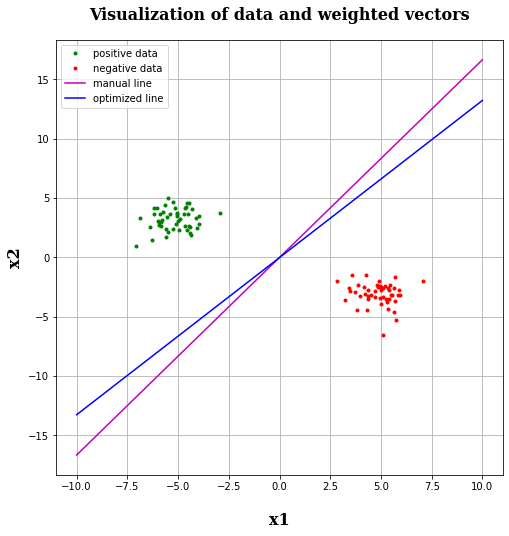

In [ ]:
def line_parameters(w):
  # compute parametric line parameters from Cartesian coordinates
  beta = -w[1] / w[2]
  gamma = -w[0] / w[2]
  return beta, gamma


from matplotlib import pyplot

# create a square plot
pyplot.figure(figsize=(8,8))

# plot the positive data points
plt.plot(X[:50,1], X[:50,2], "g.", label="positive data")
# plot the negative data points
plt.plot(X[50:,1], X[50:,2], "r.", label="negative data")

# define positions where to evaluate the line:
x1 = numpy.linspace(-10, 10, 100) # maybe we need to change this range!!!!!!

# compute line parameters for manual line
beta, gamma = line_parameters(w_manual)
# now, compute the values according to our parametric form:
x2 = beta * x1 + gamma
# plot lines (might need to call this function twice for the two lines)
pyplot.plot(x1, x2, "m-", label="manual line")

# compute line parameters for optimized line
beta, gamma = line_parameters(w_star)
# now, compute the values according to our parametric form:
x2 = beta * x1 + gamma
# plot lines (might need to call this function twice for the two lines)
pyplot.plot(x1, x2, "b-", label="optimized line")

# make the plot more beautiful
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }
pyplot.legend()
pyplot.grid(True)
plt.ylabel('x2', fontdict=font)
plt.xlabel('x1', labelpad=20.0, fontdict=font)
plt.title('Visualization of data and weighted vectors', pad=20.0, fontdict=font)


# Assignment 2: Gradient Descent

The goal of this exercise is to gain experience with a basic technique of Deep Learning, i.e., gradient descent.
A two-dimensional loss surface is created manually and gradient descent is implemented.
Several runs of gradient descent from different starting locations will be performed.
The loss surface and the detected minima are plotted together in one 3D plot.

## Compute the Gradient
The loss function is manually defined as: $$\mathcal J_{\vec w}=w_1^2 + w_2^2 + 40 \cos(w_1) \cos(w_2) + w_1 \sin(w_2)$$
The weights $\vec w = (w_1, w_2)^T$ shall be optimized such that the loss function has a minimum.

### Task 1: Compute the Gradient

The gradient $\nabla \mathcal J_{\vec w}$ is defined as the partial derivatives of the loss function with respect to the two variables $w_1$ and $w_2$.
We need to calculate it:

* $\frac{\partial \mathcal J}{\partial w_1} = 2 * w_1 - 40 sin(w_1) * cos(w_2) + sin(w_2)$
* $\frac{\partial \mathcal J}{\partial w_2} = 2 * w_2 - 40 sin(w_2) * cos(w_1) + w_1 * cos(w_2)$

### Task 2: Implement the Loss Function

Implement the loss function in Python, which takes a given $\vec w$ and returns $\mathcal J_{\vec w}$ according to the given loss function.

In [ ]:
import numpy as np

def loss(w):
  w1 = w[0]
  w2 = w[1]
  return np.square(w1) + np.square(w2) + 40 * np.cos(w1)*np.cos(w2) + w1*np.sin(w2)

### Task 3: Implement the Gradient

Implement the gradient as a function in Python, which takes a given $\vec w$ and returns $\nabla\mathcal J_{\vec w}$ according to the analytical result in Task 1. 
Remember that the gradient needs to be computed and returned for both $w_1$ and $w_2$.

In [ ]:
def gradient(w):
  w_1=w[0]
  w_2=w[1]
  w1_partdev = 2 * w_1 - 40 * np.sin(w_1) * np.cos(w_2) + np.sin(w_2)
  w2_partdev = 2 * w_2 - 40 * np.sin(w_2) * np.cos(w_1) + w_1 * np.cos(w_2)

  return np.array((w1_partdev, w2_partdev))

### Test 1: Test Functions 
The codes below call the loss function from Task 2 and the gradient function from Task 3 with $\vec w=(0,0)^T$, and then compare the return values with the given analytically computed values. 
Please check your implementation if the tests cannot be passed. 

Make sure your code can pass the test before moving to the next task.

In [ ]:
w = np.zeros(2)

# analytically computed expected values
expected_loss = 40
expected_gradient = np.array((0.,0.))

# test loss function
assert abs(loss(w) - expected_loss) < 1e-8
assert np.all(np.abs(np.array(gradient(w)) - expected_gradient) < 1e-8)
print("Tests passed")

Tests passed


## Implement Gradient Descent
The procedure of gradient decent is the repeated application of two steps:

* First, the gradient of the loss $\nabla\mathcal J_{\vec w}$ is computed based on the current value of the parameters $\vec w$.

* Second, the weights are updated by moving a small step in the direction of the negative gradient: $\vec w = \vec w - \eta\nabla\mathcal J_{\vec w}$

Optionally, the loss $\mathcal J_{\vec w}$ is computed to record the progress of the gradient descent.
Finally, one or more appropriate criteria need to be defined to decide when to stop the procedure.

### Task 4: Termination Criterion

(theoretical question) Define a proper termination criterion. Which error cases might occur and need to be considered?

A proper termination criterion for gradient descent is when the delta in the loss function between two consecutive iterations falls below a certain threshold, or when the magnitude of the gradient falls below a certain threshold. This indicates that the optimization algorithm has converged to a minimum of the loss function. We define a minimum threshold of gradient improvement at 0.000001 (current loss - new loss). This avoids getting stuck in a plateau during one iteration.

Possible errors for gradient descent are: 
* Getting stuck in a local minimum or a plateau: Gradient descent is prone to getting stuck in local minima or plateaus, where the gradient is close to zero but the loss function is not yet at its global minimum.

* Divergence: Gradient descent can also diverge, where the weights move too far in the direction of the gradient and the loss function increases instead of decreasing. This can be caused by a too large learning rate or unstable gradients, and can be mitigated by reducing the learning rate or using more advanced optimization algorithms.

* Overfitting: Gradient descent can also lead to overfitting, where the model performs well on the training data but poorly on the test data. This can be mitigated by using regularization techniques such as L1 or L2 regularization.

* Underfitting: Gradient descent may underfit, i.e. the model is too simple and does not capture the complexity of the data. This can be mitigated by increasing the complexity of the model or collecting more data.


### Task 5: Implement Gradient Descent

Implement a function that performs the gradient descent. This function should take as parameters an initial weight vector $\vec w$ and a learning rate $\eta$, and make use of the gradient function implemented in Task 3 and, possibly, the loss function from Task 2.
It should return the optimized weight vector $\vec w^*$. Incorporate the termination criterion designed in Task 4.

In [ ]:
def gradient_descent(w, eta=0.01):
    # Copy the weights to not modify the original values.
    w_star = w.copy()
    # Initialize the iteration counter.
    max_iter = 0
    # Perform iterative gradient descent.
    while max_iter < 1000:
        # Computing the loss & gradient for current w.
        curr_loss = loss(w_star)
        grad = gradient(w_star)
        
        # Update the weights.
        w_star = w_star - eta * grad
        
        # Incrementing the iteration counter.
        max_iter += 1 

        # Stopping cireteria.
        # 1: little change in loss.
        loss_new = loss(w_star)
        if np.abs(curr_loss - loss_new) < 1e-6:
            break
            
        # 2: gradient is close to 0.
        if np.linalg.norm(grad) < 1e-6:
            break

    return w_star

## Evaluate Gradient Descent

### Task 6: Run Gradient Descent
Call the gradient descent function from Task 5 1000 times with different random weights $\vec w\in[-5,5]^2$ drawn from a uniform distribution and a learning rate of $\eta=0.01$. 
Store the resulting optimized weight vectors in a list.

In [ ]:
stored_weights = []

for i in range(1000):
  # create random weight vector
  w = np.random.uniform(-5, 5, 2)
  # call gradient descent
  w_star = gradient_descent(w, eta=0.01)
  # store it in the list
  stored_weights.append(w_star)

### Test 2: Check Minima

Counting the number of local minima in our loss function, we reach a total of 12. Please use this function to verify that your implementation could reach this number at maximum.

Again, make sure you pass the test before moving to the next task.

In [ ]:
maximum_number_of_minima = 12

# compute the number of reached minima 
minima = []
for w_star in stored_weights:
  # check if this weight vector is far enough 
  # from all previously stored vectors
  if all(np.linalg.norm(w_star-w) > 1e-3 for w in minima):
    minima.append(w_star)
print(len(minima))
number_of_minima = len(minima)

assert number_of_minima <= maximum_number_of_minima

print("Check passed. The number of minima", number_of_minima, "is lower than or equal to the maximum", maximum_number_of_minima)

12
Check passed. The number of minima 12 is lower than or equal to the maximum 12


### Task 7: Find the Global Minimum

Find the global minimum of our error function by evaluating the obtained optimized weight vectors from Task 6. 
Print the minimum and its loss value.

In [ ]:
# find the lowest loss
minima_index = np.argmin([loss(m) for m in minima])
minimum_loss = loss(minima[minima_index])
minimum_weights = minima[minima_index]
#print(minima)
    

print("The minimum loss value of:", minimum_loss, "was found for minimum", minimum_weights)

The minimum loss value of: -30.70880075548177 was found for minimum [-2.9928836   0.07197497]


## Plot Error Surface and Points

### Task 8: Loss Surface Plot

Plot the error surface of the given loss function. 
Limit range $\vec w\in[-10,10]^2$. 
For each of the optimized weights from Task 6, plot a marker into the 3D plot. 
An example can be found in the slides.

When plotting the resulting optimized weights $\vec w=(w_1, w_2)^T$, we need to define the third coordinate. 
What should this coordinate be?

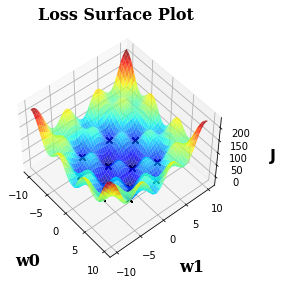

In [ ]:
from matplotlib import pyplot

# create 3D axis
figure = pyplot.figure()
axis = figure.add_subplot(111, projection='3d', azim = -40, elev=50)

# define range to plot
w_range = np.linspace(-10,10)
w1, w2 = np.meshgrid(w_range, w_range)

# compute loss for w1 and w2
J = loss(np.array([w1,w2]))

# plot surface with jet colormap
axis.plot_surface(w1, w2, J, cmap="jet", alpha=0.8)

# make the plot more beautiful
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }
pyplot.title('Loss Surface Plot',pad=20.0, fontdict=font)
pyplot.xlabel("w0", fontdict=font, labelpad=20.0)
pyplot.ylabel("w1", fontdict=font, labelpad=15.0)
axes = figure.gca()
axes.set_zlabel("J", fontsize=16, labelpad=1.0, fontweight='bold')
# plot resulting points in 3D
for w_star in stored_weights:
  # compute the z-position
  z = loss(w_star)
  # plot as 3D point
  axis.plot([w_star[0]], [w_star[1]], [z], "kx")
  

# Assignment 3: Universal Function Approximator


The goal of this exercise is to train a two-layer fully-connected network to perform one-dimensional non-linear regression via gradient descent. To show the flexibility of the approach, three different functions will be approximated. First, the network and its gradient need to be implemented. Second, target data for three different functions will be generated. Finally, the training procedure will be applied to the data, and the resulting approximated function will be plotted together with the data samples.

## Network Implementation

A two-layer network is defined by parameters $\Theta=(\mathbf W^{(1)},\vec w^{(2)})$ that are split into $\mathbf W^{(1)}\in\mathbb R^{K\times {(D+1)}}$ for the first layer and $\vec w^{(2)}\in\mathbb R^{K+1}$ for the second layer. In our case, since we have only a single input, we have $D=1$.
For a given input $\vec x = (1, x)^T$, the network is implemented in three steps:

1. Compute the first layer output, aka, the activation: $\vec a_- = \mathbf W^{(1)} \vec x$
2. Apply the activation function for each element of $\vec a_- : \vec h_- = g(\vec a_-)$ and prepend the bias neuron $h_0=1$ to arrive at $\vec h$.
3. Compute the output of the network: $y = \vec w^{(2)}\ ^T\vec h$.

### Task 1  
Implement a function that returns the network output for a given input $\vec x$ and parameters $\Theta=(\mathbf W^{(1)}, \vec w^{(2)})$. Remember that the input of the function $\vec x = (1, x)^T$. Also remember to prepend $h_0=1$ in your implementation.

We use hyperbolic tangent $(\tanh)$ as the activation function:

\begin{equation*}
    \tanh(a) = \frac{e^{a}-e^{-a}}{e^{a}+e^{-a}}
\end{equation*}

Note:

1. Use the `numpy` implemention of the hyperbolic tangent function.
2. Use `numpy.concatenate` or `numpy.insert` to prepend $h_0$.
3. Make use of `numpy.dot` to compute matrix-vector and vector-vector products.

In [ ]:
import numpy as np
import math

def network(x, Theta):
  W1, w2 = Theta
  a_ = np.dot(W1, x)
  h_ = np.tanh(a_)
  h = np.insert(h_, 0, 1)
  y = np.dot(w2, h)
  return y, h

Test 1: Sanity Check
----------------------------

We select a specific number of hidden neurons and create the weights accordingly, using all zeros in the first layer and all ones in the second. The test case below assures that the function from Task 1 actually returns $1$ for those weights.

Note: your function should pass the test below.

In [ ]:
K = 20
D = 1
W1 = np.zeros((K, D+1))
w2 = np.ones(K+1)
x = np.random.rand(D+1)

y, _ = network(x, (W1, w2))
assert abs(1 - y) < 1e-6
print("Test passed")

Test passed


## Gradient Implementation

In order to perform gradient descent, we need to define a loss function. As provided in the lecture, the $\mathcal J^{L_2}$ loss function is defined over a dataset $X=\{(\vec x^{[n]}, t^{[n]})\}$, that is defined as a list of tuples, as follows:

$$
   \mathcal J^{L_2} = \frac{1}{N}\sum_{i=1}^N (y^{[n]}-t^{[n]})^2
$$

where $y^{[n]}$ is the output of the network from Task 1 when inputting $\vec x^{[n]}$. Interestingly, however, we never explicitly need to compute the output of the loss function. It is only used to analytically compute the gradient as shown in the lecture.

The gradient is composed of two items, one for each layer. Particularly, for a given dataset $X$, the gradient of loss $J^{L_2}$ is defined as:

\begin{align}
  \frac{\partial \mathcal J}{\partial w_{kd}^{(1)}} &= \frac{2}{N} \sum\limits_{n=1}^N (y^{[n]}-t^{[n]}) w_{k}^{(2)} (1-h_{k}^{[n]}\cdot h_{k}^{[n]}) x_{d}^{[n]}\\
  \frac{\partial \mathcal J}{\partial w_{k}^{(2)}} &= \frac{2}{N} \sum\limits_{n=1}^N (y^{[n]}-t^{[n]}) w_{k}^{(2)} h_{k}^{[n]}
\end{align}

### Task 2
Implement a function that returns the gradient as defined in $(1)$ and $(2)$ for a given dataset $X$, and given weights $\Theta=(\mathbf W^{(1)},\vec w^{(2)})$. Make sure that both parts of the gradient are computed. 

Hint:

1. Make use of the the function implemented in Task 1 where appropriate

Note:

  1. This is a slow implementation. We will see how to speed this up in the next lecture.
  2. You can make use of `numpy.zeros` to initialize the gradient.
  3. The outper product can be computed via `numpy.outer`.
  4. Remember that we used the $\tanh$ activation function in our network.

In [ ]:
def gradient(X, Theta):
  # split parameters for easier handling
  W1, w2 = Theta
  
  # define gradient with respect to both parameters
  dW1 = np.zeros((len(W1), len(W1[0])))
  dw2 = np.zeros(len(w2))

  # iterate over dataset
  for x, t in X:
    # compute the gradient
    y, h = network(x, Theta)
    loss_w1 = np.outer((y-t)*w2*(1-h*h), x)
    loss_w2 = (y-t)*h
    dW1 += loss_w1[1:]
    dw2 += loss_w2
    

  # anything else?
  dW1 = dW1 * (2/len(X))
  dw2 = dw2 * (2/len(X))
  
  
  return dW1, dw2

## Gradient Descent

The procedure of gradient descent is the repeated application of two steps.
 
1. The gradient of loss $\nabla_{\Theta}\mathcal J^{L_2}$ is computed based on the current value of the parameters $\Theta=(\mathbf W^{(1)},\vec w^{(2)})$.
2. The weights are updated by moving a small step $\eta$ into the direction of the negative gradient:

$$
    \Theta = \Theta - \eta \nabla_{\Theta}\mathcal J
$$

As stopping criterion, we select the number of training epochs to be 10000.

### Task 3
Implement a function that performs gradient descent for a given dataset $X$, given initial parameters $\Theta$ and a given learning rate $\eta$ and returns the optimized parameters $\Theta^*$.

In [ ]:
def gradient_descent(X, Theta, eta):
  epochs = 10000
  # perform iterative gradient descent
  for epoch in range(epochs):
    # compute the gradient
    gradient_value = gradient(X, Theta)

    # update the parameters
    W1, w2 = Theta
    W1 -= eta*gradient_value[0]
    w2 -= eta*gradient_value[1]


  # return optimized parameters
  return Theta

## Generate Datasets

In total, we will test our gradient descent function with three different datasets. Particularly, we approximate:

1. $X_1: t = \sin(2x)$ for $x\in[-2,2]$
2. $X_2: t = e^{-2x^2}$ for $x\in[-2,2]$
3. $X_3: t = -x^5 - 3x^4 + 11x^3 + 27x^2 - 10x - 64$ for $x\in[-4.5,3.5]$

### Task 4

Generate dataset $X_1$, for $N=50$ samples randomly drawn from range $x\in[-2,2]$. 
Generate data $X_2$ for $N=30$ samples randomly drawn from range $x\in[-2,2]$. 
Generate dataset $X_3$ for $N=200$ samples randomly drawn from range $x\in[-4.5,3.5]$. 
Implement all three datasets as lists of tuples: $\{(\vec x^{[n]}, t^{[n]})\mid 1\leq n\leq N\}$.

Note:

  1. You can use `numpy.random.uniform` to create uniformly distributed samples for $x$.
  2. Make sure that $\vec x = (1, x)^T$ for each sample.
  3. You can make use of `numpy.sin`, `numpy.exp` and `numpy.pow` to compute target values.

In [ ]:
X1 = []
for i in range(50):
    random_x = np.random.uniform(-2,2)
    X1.append(((1, random_x), np.sin(2*random_x)))

X2 = []
for i in range(30):
    random_x = np.random.uniform(-2,2)
    X2.append(((1, random_x), np.exp(-2*(random_x**2))))

X3 = []
for i in range(200):
    random_x = np.random.uniform(-4.5,3.5)
    X3.append(((1, random_x), (-random_x**5) - 3*random_x**4 + 11*random_x**3 + 27*random_x**2 - 10*random_x - 64))


### Test 2: Sanity Check

The test case below assures that the elements of each generated dataset are tuples with two elements, that the first element ($\vec x$) is a vector with two numbers, and that the second element ($t$) is a float.

In [ ]:
assert all(
    isinstance(x, (tuple,list)) and 
    len(x) == 2 and 
    isinstance(x[0], (tuple,list,np.ndarray)) and 
    len(x[0]) == 2 and 
    isinstance(x[1], float)
    for X in (X1, X2, X3)
    for x in X
) # changed test because maybe test error

print('Test passed!')

Test passed!


## Function Approximation

Finally, we want to make use of our gradient descent implementation to approximate our functions. In order to see our success, we want to plot the functions together with the data.

### Task 5 (theoretical question)

When looking at the example plots in the exercise slides (exemplary solutions for the plotting Task 8), how many hidden neurons $K$ do we need in order to approximate the functions? Is there any difference between the three target functions?

In [ ]:

K1 = 3
K2 = 4
K3 = 120
# All functions have the same dimensionality.

### Task 6

For each of the datasets, randomly initialize the parameters $\Theta_1,\Theta_2,\Theta_3\in[-1,1]$ according to the number of hidden neurons estimated in Task 5.

Note:

  1. You can use `numpy.random.uniform` to initialize the weights.
  2. Make sure that the weight matrices are instantiated in the correct dimensions.

In [ ]:
# Not fully sure about the dimensions of the matrices
Theta1 = (np.random.uniform(-1,1,(K1,2)), np.random.uniform(-1,1,K1+1))
Theta2 = (np.random.uniform(-1,1,(K2,2)), np.random.uniform(-1,1,K2+1))
Theta3 = (np.random.uniform(-1,1,(K3,2)), np.random.uniform(-1,1,K3+1))

### Task 7

Call gradient descent function from Task 3 using the datasets $X_1, X_2, X_3$, the according created parameters $\Theta_1,\Theta_2,\Theta_3$ and a learning rate of $\eta=0.1$. Store the resulting optimized weights $\Theta_1^*, \Theta_2^*, \Theta_3^*$ and the loss values.

Optimize the learning rate $\eta$ for each of the three functions. Do you see any differences? What are the best learning rates that you can find?

WARNING: Depending on the implementation, this might run for several minutes!

In [ ]:
eta = 0.1
T1 = gradient_descent(X1, Theta1, eta) # maybe we can use 0.5, I dont want to run these cells 
T2 = gradient_descent(X2, Theta2, eta) 
T3 = gradient_descent(X3, Theta3, eta/150) 

## Data and Function Plotting

### Task 8

Implement a plotting function that takes a given dataset $X$, given parameters $\Theta$ and a defined range $R$. Each data sample $(x^{[n]},t^{[n]})$ of the dataset is plotted as an $''x''$. In order to plot the function that is approximated by the network, generate sufficient equally-spaced input values $x\in R$, compute the network output $y$ for these inputs, and plot them with a line.

Note:

  1. The dataset $X$ is defined as above, a list of tuples $(\vec x, t)$.
  2. Each input in the dataset is defined as $\vec x = (1,x)^T$.
  3. Equidistant points can be obtained via `numpy.arange`.

In [ ]:
from matplotlib import pyplot
def plot(X, Theta, R):
  # first, plot data samples
  pyplot.plot([x[1] for (x,t) in X], [t for (x,t) in X], "rx", label="Data")

  # define equidistant points from R[0] to R[1] to evaluate the network
  x = np.arange(R[0], R[1], 0.001)
  # compute the network outputs for these values
  y = [network((1,v), Theta)[0] for v in x]

  # plot network approximation
  pyplot.plot(x,y,"k-", label="network")
  pyplot.legend()

### Task 9

For each of the datasets and their according optimized parameters, call the plotting function from Task 8. Use range $R=[-3,3]$ for dataset $X_1$ and $X_2$, and range $R=[-5.5,4.5]$ for dataset $X_3$. Note that the first element of range $R$ should be the lowest $x$-location, and the second element of $R$ the highest value for $x$. Did the networks approximate the functions? What can we do if not?

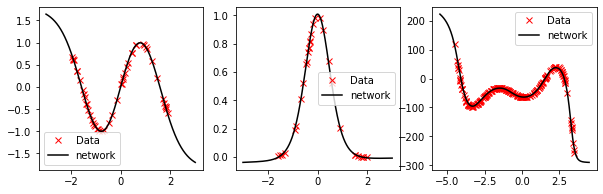

In [ ]:
figure = pyplot.figure(figsize=(10,3))

# plot first function
pyplot.subplot(131)
plot(X1, Theta1, [-3,3])

# plot second function
pyplot.subplot(132)
plot(X2, Theta2, [-3,3])

# plot third function
pyplot.subplot(133)
plot(X3, Theta3, [-5.5, 4.5])

# Assignment 4: Multi-Output Networks and Batch Processing


The goal of this exercise is to get to know some regularization techniques when implementing deep learning methods.
For this purpose, we select a dataset that contains data in different formats, some binary ($x_d \in \{-1,1\}$) and some numerical ($x_d\in \mathbb N$); and some are categorical, which we ignore for now.
As target values, this dataset contains three numerical outputs, so, $\vec t \in \mathbb R^3$ for each sample.
These target values should be approximated with a two-layer multi-output network that we will train with the $\mathcal J^{L_2}$ loss.



Remember to make use of `numpy` in the matrix calculation, e.g. `numpy.dot`, `numpy.exp`, `numpy.mean` 


## Dataset

The dataset of our choice is the Student Performance estimation dataset that was collected in Portugal in two different schools and with two different subjects, i.e., math and Portuguese (the mother tongue).
The dataset contains many different inputs such as a binary representation of the school, gender, family sizes, and alike, as well as numerical representations of age, travel time, and alcohol consumption.
The dataset also includes some categorical data, which we skip in this assignment.
See https://archive.ics.uci.edu/ml/datasets/Student+Performance for more information on the dataset.
As a start, we will rely on the Portuguese performance (`"por"`), but you can also try to use the Math samples (`"mat"`).

### Task 1: Dataset Loading


Load the dataset from files and provide the input matrix $\mathbf X \in \mathbb R^{(D+1)\times N}$ and the output matrix $\mathbf T \in \mathbb R^{O\times N}$.

Due to the difficulty of the task, most of the implementation is provided.
The implementation is very literal and, therefore, hopefully readable, while maybe not the most efficient.

We skip categorical inputs (indexes 8-11) for now.
All other entries are converted either into binary $(-1,1)$ or into an integer range $(0,1,\ldots)$.
The three outputs range between 0 and 20 each. The bias value for $x_0=1$ is also already included.
You just need to make sure that the data $(X,T)$ is returned in the desired format.

In [ ]:
import math
import numpy as np
import os

# Dataset origin: https://archive.ics.uci.edu/ml/datasets/Student+Performance

def dataset(course="por"):
  # load dataset and provide input and target data
  # possible data files are "mat" and "por"

  # download data file from URL
  dataset_zip_file = "student.zip"
  if not os.path.exists(dataset_zip_file):
    import urllib.request
    urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", dataset_zip_file)
    print ("Downloaded datafile", dataset_zip_file)

  import zipfile
  import csv
  import io

  # collect inputs
  inputs = []
  targets = []
  # some default values: yes=1, no=-1
  yn = {"yes":1.,"no":-1.}
  # read through dataset (without actually unzippiung to a file):
  # ... open zip file
  zip = zipfile.ZipFile(dataset_zip_file)
  # ... open data file inside of zip file and convert bytes to text
  datafile = io.TextIOWrapper(zip.open(os.path.join(F"student-{course}.csv"), 'r'))
  # ... read through the lines via CSV reader, using the correct delimited
  reader = csv.reader(datafile, delimiter=";")
  # ... skip header line
  next(reader)
  for splits in reader:
    # read input values
    inputs.append([
      1.,                             #### BIAS ####
      {"GP":1.,"MS":-1.}[splits[0]],  # school
      {"M":1.,"F":-1.}[splits[1]],    # gender
      float(splits[2]),               # age
      {"U":1.,"R":-1.}[splits[3]],    # address
      {"LE3":1.,"GT3":-1.}[splits[4]],# family size
      {"T":1.,"A":-1.}[splits[5]],    # parents living together
      float(splits[6]),               # mother education
      float(splits[7]),               # father education
      # skip categorical values
      float(splits[12]),              # travel time
      float(splits[13]),              # study time
      float(splits[14]),              # failures
      yn[splits[15]],                 # extra support
      yn[splits[16]],                 # family support
      yn[splits[17]],                 # paid support
      yn[splits[18]],                 # activities
      yn[splits[19]],                 # nursery school
      yn[splits[20]],                 # higher education
      yn[splits[21]],                 # internet
      yn[splits[22]],                 # romantic
      float(splits[23]),              # family relation
      float(splits[24]),              # free time
      float(splits[25]),              # going out
      float(splits[26]),              # workday alcohol
      float(splits[27]),              # weekend alcohol
      float(splits[28]),              # health
      float(splits[29]),              # absences
    ])

    # read targets values
    targets.append([
      float(splits[30]),              # grade for primary school
      float(splits[31]),              # grade for secondary school
      float(splits[32]),              # grade for tertiary school
    ])

  print(F"Loaded dataset with {len(targets)} samples")
  return np.transpose(np.array(inputs)), np.transpose(np.array(targets))

### Test 1: Assert Valid Outputs

This test will check the dimension of the loaded dataset, i.e. $\mathbf X\in \mathbb R^{(D+1)\times N}$ and $\mathbf T \in \mathbb R^{O\times N}$, and also assure that all target data is in the range $t\in[0,20]$.

Please make sure that your implementation can pass these tests before moving to the next task

In [ ]:
X, T = dataset("por")

assert np.all(T >= 0) and np.all(T <= 20)

assert X.shape[0] == 27
assert T.shape[0] == 3
assert T.shape[1] == X.shape[1]

Loaded dataset with 649 samples


### Task 2: Input Data Standardization

Since the data is in different input regimes, we want to standardize the data.
For this purpose, we need to compute the mean and the standard deviation of the data for each input dimension.
Then, we implement a function to perform the standardization of the data using the previously computed mean and standard deviation. Make sure that you handle the bias neuron $x_0$ correctly.

Please note that `numpy` has all the functionality that you need.

In [ ]:
# compute mean and standard deviation over dataset
mean = np.mean(X, axis=1)
std = np.std(X, axis=1)
# assure to handle x_0 correctly
mean[0] = 0
std[0] = 1
### We want that after the standardization the first values should remain 1 as a bias. Therefore we define the mean and std as 0 and 1 because (1-0) / 1 == 1

def standardize(x, mean, std):
  # standardize the given data with the given mean and standard deviation
  return np.transpose((np.transpose(x) - mean) / std )

# standardize our dataset
X = standardize(X, mean, std)

### Task 3: Batch Processing

In order to run stochastic gradient descent, we need to split our dataset into batches of a certain batch size $B$. Implement a function that turns the dataset $(X,T)$ into batches of a certain batch size $B$.
Implement this function as a generator function, i.e., use ``yield`` instead of ``return``.
Circulate the dataset afresh when all data is consumed, and shuffle the data in each epoch.
Make sure that you yield both the input batch and the target batch.

In [ ]:
def batch(X, T, batch_size=16):
  shuff_X = np.random.permutation(X.shape[1])
  i=0
  while True:
    # shuffle dataset in each epoch
    if(i+batch_size)>= X.shape[1]:
      i=0
      shuff_X=np.random.permutation(X.shape[1])
    # yield the batch
    yield X[:, shuff_X[i:i+batch_size]], T[:, shuff_X[i:i+batch_size]]
    i += batch_size 

### Test 2: Test your Batches

This test is to assure that your batch generation function works as expected. 
We define some test data for this purpose.
The code below checks whether your batch function returns batches with correct content, i.e., $(\vec x, \vec t)$-alignment. 
It also checks that the batches are in the correct dimensions, i.e., that $\mathbf X \in \mathbb R^{(D+1)\times B}$ and $\mathbf T \in \mathbb R^{O\times B}$.

Make sure you can pass this test before moving forward.

In [ ]:
XX = np.array([[i] * 5 for i in range(50)]).T
TT = np.array([[i] for i in range(10,60)]).T

for counter, (x,t) in enumerate(batch(XX, TT, 16)):
  assert x.shape[0] == 5
  assert x.shape[1] == 16
  assert t.shape[0] == 1
  assert t.shape[1] == 16
  assert np.all(x == t-10)
  if counter == 20: break

## Gradient Descent

To train a two-layer multi-output regression network, we need to implement some functions.
The network output is computed in three steps:

  * Compute network activation for a batch of inputs $\mathbf X$: $\mathbf A = \mathbf W^{(1)}\mathbf X$
  * Call the activation function element-wise: $\mathbf H = g(\mathbf A)$. Here, we rely on the logistic activation function $\sigma$. Assure that the hidden neuron bias $\mathbf H_{0,:}$ is set appropriately.
  * Compute the output $\mathbf Y$ of the batch: $\mathbf Y = \mathbf W^{(2)}\mathbf H$.

### Task 4: Multi-Output Network

Implement a multi-target network that computes the output matrix $\mathbf Y$ for a given input dataset/batch $\mathbf X$ and given parameters $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$ using `numpy` operations. 
The function should return both the output $\mathbf Y$ and the output of the hidden units $\mathbf H$ since we will need these in gradient descent. Select the logistic function $\sigma$ as the activation function.

In [ ]:
def network(X, Theta):
  W1, W2 = Theta

  # compute activation
  A = np.dot(W1, X)

  # compute hidden unit output
  H = 1 / (1 + np.exp(- A))
  H[0] = 1

  # compute network output
  Y = np.dot(W2, H)

  return Y, H

### Task 5: Loss Implementation

Implement a loss function that returns the squared loss $\mathcal J^{L_2} = \frac1B \|\mathbf Y - \mathbf T\|_F^2$ for given network outputs $\mathbf Y$ and target values $\mathbf T$.
Use `numpy` or `scipy` functionality for this task.

In [ ]:
def loss(Y, T):
  B = T.shape[1]
  return (1/B) * np.square(np.linalg.norm(Y - T))

### Task 6: Gradient Implementation

Implement a function that computes and returns the gradient for a given batch $(\mathbf X, \mathbf T)$, the given network outputs $\mathbf Y$ and $\mathbf H$ as well as current parameters $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$.
Make sure to compute the gradient with respect to both weight matrices. Remember that we have used $\sigma$ as the activation function.
Implement the function using the fast version provided in the lecture and make use of `numpy` operations.

In [ ]:
def gradient(X, T, Y, H, Theta):
  W1, W2 = Theta

  # first layer gradient
  g1 = (2/Y.shape[1]) * np.dot((np.dot(W2.T, (Y-T))) * H * (1-H),  X.T)
  # second layer gradient
  g2 = (2/Y.shape[1]) * np.dot((Y-T), H.T)
  
  return g1, g2

### Task 7: Iterative Gradient Descent


Implement gradient descent for a given number of 10'000 epochs (**not batches!**) using given initial parameters $\Theta$ and a given batch size $B$, as well as a learning rate of $\eta=0.001$.

Make use of the standardized dataset from Task 2, split into batches with the function from Task 3, the network from Task 4, the loss from Task 5, and the gradient from Task 6.

Make sure that the network output $\mathbf Y$ and the hidden unit output $\mathbf H$ are computed only once for each batch. After applying gradient descent, add an option to use momentum learning with the given parameter `mu`.
At the end of each epoch, compute and store the loss values for each batch in a list, and this list will be returned at the end.

How many iterations do we need when $B < N$? How can you know whether your current batch is the last one of the current epoch?

In [ ]:
def gradient_descent(X, T, Theta, B, eta=0.001, mu=None):
  loss_values = []
  W1, W2 = Theta

  max_epochs = 10000

  # max_batches are the length of the X[1] shape divided by batch size B
  max_batches = X.shape[1] // B

  # epoch counter to know when an epoch ends
  curr_epoch = 0
  generator_call = batch(X, T, batch_size=B)

  # iterate over batches
  for count, (x,t) in enumerate(generator_call):
    max_batches -=1
    # break if we reach maximum amount of epochs
    if curr_epoch > max_epochs:
      break

    # compute network output
    y, h = network(x, (W1, W2))
    # compute and append loss
    loss_curr = loss(y,t)
    # check if we went through one epoch and fix parameters
    if max_batches == 0:
      loss_values.append(loss_curr)
      max_batches = X.shape[1] // B
      curr_epoch += 1

    # compute gradient
    grad1, grad2 = gradient(x, t, y, h, (W1, W2))

    # inizialize W_prev if it is the first iteration
    if count == 0:
      W1_prev = np.zeros(W1.shape)
      W2_prev = np.zeros(W2.shape)
    else:
      # set W_prev if it is not the very first iteration
      W1_prev = W1_curr
      W2_prev = W2_curr

    # set W_curr to the correct value  
    W1_curr = W1
    W2_curr = W2

    # and apply gradient descent
    W1 -= eta*grad1
    W2 -= eta*grad2
    
    # apply momentum learning if asked
    if mu:
      W1 += mu * (W1_curr - W1_prev)
      W2 += mu * (W2_curr - W2_prev)

  # return the obtained loss values at the end
  # print(loss_values)
  return loss_values

### Task 8: Run Gradient Descent

Select an appropriate number of hidden neurons $K$.
Instantiate the weight matrices $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$ using the Xavier method as introduced in the lecture.

Run the gradient descent three times, first as normal gradient descent, second as stochastic gradient descent with batch size $B=16$, and third with the same setup as the second but with momentum learning involved, select $\mu =0.9$.

How can you achieve this without requiring separate implementations of the ``gradient_descent`` function from Task 7?

In [ ]:
K = 25
D = X.shape[0]
O = 3
W1 = np.random.uniform(-1 / np.sqrt(D), 1 / np.sqrt(D), (K+1, D))
W2 = np.random.uniform(-1 / np.sqrt(K), 1 / np.sqrt(K), (O, K+1))
Theta = [W1, W2]

import copy

# run gradient descent with full dataset
Theta1 = copy.deepcopy(Theta)
GD = gradient_descent(X, T, Theta1, B=len(X[0]), eta=0.001)


# run stochastic gradient descent with batches of size 16
Theta2 = copy.deepcopy(Theta)
SGD = gradient_descent(X, T, Theta1, B=16, eta=0.001)


# run stochastic gradient descent with batches of size 16 and momentum mu=0.9
Theta3 = copy.deepcopy(Theta)
SGD_Mo = gradient_descent(X, T, Theta1, B=16, eta=0.001, mu=0.9)


## Evaluation

Finally, we want to evaluate how the learning process went and what the network has actually learned.
For the former, we will plot the loss values obtained during training.
For the latter, we define one specific sample of our own, and we evaluate the impact of several factors on the performance.

### Task 9: Plotting Loss Progression

To show the learning process of the networks, plot the loss values of the three gradient descent steps from Task 8 together into one plot.
Do we need to take care of something when plotting both together?

Use logarithmic axes wherever you see fit.
An exemplary loss progression plot can be found in the slides.



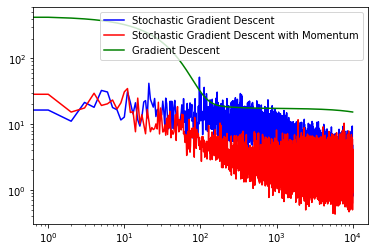

In [ ]:
from matplotlib import pyplot

pyplot.plot(SGD, "b-", label="Stochastic Gradient Descent")
pyplot.plot(SGD_Mo, "r-", label="Stochastic Gradient Descent with Momentum")
pyplot.plot(GD, "g-", label="Gradient Descent")
pyplot.loglog()
pyplot.legend()
pyplot.show()

### Task 10: Example Evaluation (optional)

We want to see what the network has learned.
Therefore, we evaluate some data points that would represent a typical Swiss student (except for the school entry, where we select one of them randomly).
You can select a specific example, but you can also imagine a student.
Please refer to https://archive.ics.uci.edu/ml/datasets/Student+Performance on possible values and the implementation in Tasks 1 and 2 on how to generate an input sample $\vec x$ for our network. Also, remember that input data need to be standardized before feeding it to the network. 

Compute the scores that your student would likely get by asking the network, using the parameters $\Theta$ optimized with stochastic gradient descent.



In [ ]:
# select a specific example
example = np.array([[
  1.,    # BIAS
  ...,   # school (select -1 or 1)
  ...,   # gender
  ...,   # age
  ...,   # adress
  ...,   # family size
  ...,   # parents living together
  ...,   # mother education
  ...,   # father education
  ...,   # travel time
  ...,   # study time
  ...,   # class failure before

  ...,   # support from school
  ...,   # support from the family
  ...,   # paid extra support 
  ...,   # out-of-school activities
  ...,   # nursery school
  ...,   # want to do higher ed
  ...,   # internet access
  ...,   # romantic relation

  ...,   # relation to family
  ...,   # amount of free time
  ...,   # go out with peers
  ...,   # alcoholic drinks during the week
  ...,   # alcoholic drinks in the weekend
  ...,   # health status
  ...    # days of absence
]]).T

# compute network output
prediction = ...
print("Prediction :\t", prediction)

Prediction :	 Ellipsis


### Task 11: Influence of Data Dimensions (optional)


For some dimensions in the input feature $\vec x$, we want to test how different input values for this dimension would influence the outcome.
Particularly, we test:

  * Gender at index $d=2$: change between male ($1$) and female ($-1$)
  * Weekly study time at index $d=10$: vary in the range $[1,4]$ 
  * Past Failures at index $d=11$: vary in range $[0,3]$ 
  * Additional classes at index $d=14$: change between yes ($1$) and no ($-1$)
  * Romantic relations at index $d=19$: change between yes ($1$) and no ($-1$)
  * Weekday alcohol consumption at index $d=23$: varies in the range $[1,6]$.

Note that the indexes include the fact that we are omitting some input dimensions, so they might differ from what is listed on the webpage.

Did you expect this output?



In [ ]:
# implement a way to modify the input at a given index with certain values
# and to predict and print the network output for this modification
...
# run this with the 4 modifications and their according to values as seen above
...

Ellipsis

# Assignment 5: Classification in PyTorch 


For this exercise, we will switch to an implementation in PyTorch. 
The goal of this exercise is to get used to some concepts in PyTorch, such as relying on the `torch.tensor` data structure, implementing the network, the loss functions, the training loop and accuracy computation, which we will apply to binary and categorical classification.

Please make sure that all your variables are compatible with `torch`.
For example, you cannot mix `torch.tensor`s and `numpy.ndarray`s in any part of the code.

## Dataset

We will use two different datasets, the *spambase* dataset https://archive.ics.uci.edu/ml/datasets/spambase for binary classification and the *wine* dataset https://archive.ics.uci.edu/ml/datasets/wine for categorical classification. Both datasets are available on the UCI Machine Learning repository. 
The binary classification dataset contains features extracted from emails, which are classified as either spam or not. 
The categorical classification dataset contains some manually selected features for three different types of wines. 
For the former, the class is provided in the last column of the data file, whereas for the latter, the first index provides class information.

Please run the code block below to download the data files.

In [ ]:
import os
import torch

# download the two dataset files
dataset_files = {
  "spambase.data": "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/",
  "wine.data": "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/"
}
for name, url in dataset_files.items():
  if not os.path.exists(name):
    import urllib.request
    urllib.request.urlretrieve(url+name, name)
    print ("Downloaded datafile", name)

### Task 1: Dataset Loading

The first task deals with the loading of the datasets. 
When training networks in PyTorch, all data needs to be stored as datatype ``torch.tensor``. 
The data should be split between input sets $\mathbf X = [\vec x^{[1]}, \ldots, \vec x^{[N]}]^T \in \mathbb R^{N\times D}$ and targets.
There is **no need to add a bias neuron to the input**, and the transposition of the data matrix is different from what we have seen before.

For the targets, we have to be more careful as there are differences w.r.t. the applied loss function.
For binary classification, we need $\mathbf T = [[t^{[1]}, \ldots, t^{[N]}]]$ to be in dimension $\mathbb R^{N\times1}$ and of type ``torch.float``.
For categorical classification, we only need the class indexes $\vec t = [t^{[1]}, \ldots, t^{[N]}]$ to be in dimension $\mathbb N^N$ and of type ``torch.long``.

Implement a function that returns both the input and the target data for a given dataset

Note:

1. You can use `csv.reader()` to read the dataset, or rely on other methods such as `pandas`.
2. For the wine dataset, subtract the target by `-1` to get the target values in range $\{0, 1, 2\}$.
3. Be aware both datasets are sorted w.r.t. their labels.

In [ ]:
import pandas as pd
import numpy as np

def dataset(dataset_file="wine.data"):
  # read dataset
  data = []
  with open(dataset_file, 'r') as f:
    data = pd.read_csv(f)

  print (f"Loaded dataset with {len(data)} samples")
  
  # convert to torch.tensor
  torch_data = torch.tensor(data.values)

  if dataset_file == "wine.data":
    # target is in the first column and needs to be converted to long
    X = torch_data[:, 1:].float()
    T = torch_data[:, 0].long() - 1
  else:
    # target is in the last column and needs to be of type float
    X = torch_data[:, :-1].float()
    T = torch_data[:, -1:].float()
 
  return X, T

### Test 1: Dataset Check

Test 1 assures the correctness of the data and target dimensions.

1. For the wine dataset, we make sure that the dataset is in the correct dimensions, i.e., $\mathbf X\in \mathbb R^{N\times D}$ and $\mathbf T \in \mathbb N^N$. And all class labels are in the correct range $[0, O-1]$ where $O$ is the number of classes.

2. For the spambase data, we assure that all dimensions are correct and that class labels are in range $\{0, 1\}$.

In [ ]:
X, T = dataset("wine.data")

assert X.shape[1] == 13, X.shape[1]
assert torch.all(T >= 0) and torch.all(T <= 2)
assert T.dtype == torch.long

X, T = dataset("spambase.data")
assert X.shape[1] == 57, X.shape[1]
assert T.shape[1] == 1, T.shape[1]
assert torch.all(T >= 0) and torch.all(T <= 1)
assert T.dtype == torch.float

Loaded dataset with 177 samples
Loaded dataset with 4600 samples


### Task 2: Split Training and Validation Data

The data should be split into 80% for training and 20% for validation. Implement a function that takes the full dataset $(X,T)$ and returns $(X_t, T_t, X_v, T_v)$ accordingly.

Write a function that splits off training and validation samples from a given dataset. What do we need to assure before splitting?

In [ ]:
def split_training_data(X,T,train_percentage=0.8):
  # we need to shufffle the dataset to make sure we have different training sets
  length_dataset = len(X)

  # generate and shuffle indices
  indices = np.arange(length_dataset)
  indices = np.random.permutation(indices)
  
  # assign indices to datastes
  X = X[indices]
  T = T[indices]
  
  # split into 80/20 training/validation
  X_train = X[:int(train_percentage*length_dataset)]
  T_train = T[:int(train_percentage*length_dataset)]
  X_val = X[int(train_percentage*length_dataset):]
  T_val = T[int(train_percentage*length_dataset):]

  return X_train, T_train, X_val, T_val

### Task 3: Input Data Standardization

As we have seen last week, the standardization of the data provides many advantages. 
Hence, in this task you should write a function that takes $(X_t,X_v)$ as input and standardizes them by subtracting the mean and dividing by the 
standard deviation of $X_t$, and returning the standardized versions of both. Assure that each input dimension is standardized individually.

Implement a function that standardizes all input data for the training and validation set.
Return the standardized data.

Note:

1. Use `torch.mean()` and `torch.std()` with the correct dimensions.

In [ ]:
def standardize(X_train, X_val):
  # compute statistics
  mean = torch.mean(X_train, dim = 0)
  std = torch.std(X_train, dim = 0)

  # standardize both X_train and X_val
  X_train = (X_train - mean) / std
  X_val = (X_val - mean) / std

  return X_train, X_val

## Network Implementation

We will use a two-layer fully-connected network with $D$ input neurons, $K$ hidden neurons and $O$ output neurons. 
Depending on the task, $D$ and $O$ need to be selected appropriately, while $K$ is a parameter to play around with. 
In PyTorch, the easiest way to implement a network is by providing the requested sequence of layers to `torch.nn.Sequential`, which will build a network containing the given layers. 
We will use two `torch.nn.Linear` layers and one `torch.nn.Tanh` activation function in between. 
The network will return the logits $\vec z$ for a given input $\vec x$.


### Task 4: Implement Network

Implement a two-layer fully-connected network in PyTorch. 
The given network uses $\tanh$ as activation function, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.

In [ ]:
def Network(D, K, O):
  return torch.nn.Sequential(
    torch.nn.Linear(D, K),  
    torch.nn.Tanh(),
    torch.nn.Linear(K, O)
  )

### Task 5: Accuracy Computation

To monitor the training process, we want to compute the accuracy. 
The function will obtain the logits $\vec z$ extracted from the network and the according target $t$. 
Assure that this function works both for binary and categorical classification. 
How can we identify, which of the two variants is currently required?

Note: you can make use of the following pytorch functions:

1. `torch.mean()` which computes the mean or average of the input tensor.
2. `torch.argmax()` which returns the indices of the maximum values of all elements of the tensor.

In [ ]:
def accuracy(Z, T):
  # check if we have binary or categorical classification
  if len(T.shape) == 2:
    # binary classification
    # assign bin_value = 1 if Z is larger equal 0
    bin_value = (Z >= 0)
    return torch.mean((bin_value == T).float())
  else:
    # categorical classification
    # assign cat_value based on maximum value
    cat_value = torch.argmax(Z, dim = 1)
    return torch.mean((cat_value == T).float())

### Test 2: Test Accuracy Function

Test 2 assures the correctness of your accuracy function in both binary and categorical cases. We make sure that the accuracy will compute the correct values.

In [ ]:
# first, test binary classification
ZZ = torch.ones((20,1)) * -5.
ZZ[15:20] = 5
assert(abs(accuracy(ZZ,torch.zeros((20,1))) - 0.75) < 1e-8)
assert(abs(accuracy(ZZ,torch.ones((20,1))) - 0.25) < 1e-8)

# now, test categorical classification with 4 classes
ZZ = torch.ones((20,4)) * -5
ZZ[0:1,0] = 5
ZZ[1:4,1] = 5
ZZ[4:10,2] = 5
ZZ[10:20,3] = 5

assert(abs(accuracy(ZZ,torch.zeros(20)) - 0.05) < 1e-8)
assert(abs(accuracy(ZZ,torch.ones(20)) - 0.15) < 1e-8)
assert(abs(accuracy(ZZ,torch.ones(20)*2) - 0.3) < 1e-8)
assert(abs(accuracy(ZZ,torch.ones(20)*3) - 0.5) < 1e-8)
assert(abs(accuracy(ZZ,torch.tensor((0,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3))) - 1.) < 1e-8)

### Task 6: Training Loop

Implement a function that takes all necessary parameters to run a training on a given dataset.
In this week, we will run gradient descent, i.e., we will train on the whole dataset in each training step, so there is no need to define anything related to batches. 
Select the optimizer to be `torch.optim.SGD`. 

Implement a training loop over 10'000 epochs with a learning rate of $\eta=0.1$. 
Make sure that you train on the training data only, and **not** on the validation data.
In each loop, compute and store the training loss, training accuracy, validation loss and validation accuracy. 
At the end, return the lists of these values.

Note:

1. When storing accuracy or loss values in a list, make sure to convert the to float via `v.item()`.

In [ ]:
def train(X_train, T_train, X_val, T_val, network, loss_function, epochs = 10000, learning_rate = 0.1):
  optimizer = torch.optim.SGD(params = network.parameters(), lr = learning_rate)

  # collect loss and accuracy values
  train_loss, train_acc, val_loss, val_acc = [], [], [], []

  for epoch in range(epochs):
    # train on training set
    # ... compute network output on training data
    optimizer.zero_grad()
    Z = network(X_train)
    # ... compute loss from network output and target data
    J = loss_function(Z, T_train)
    J.backward()
    # ... perform parameter update
    optimizer.step()
    # ... remember loss
    train_loss.append(J.item())
    # ... compute training set accuracy
    train_acc.append(accuracy(Z, T_train).item())

    # test on validation data
    with torch.no_grad():
      # ... compute network output on validation data
      Z = network(X_val)
      # ... compute loss from network output and target data
      J = loss_function(Z, T_val)
      # ... remember loss
      val_loss.append(J.item())
      # ... compute validation set accuracy
      val_acc.append(accuracy(Z, T_val).item())

  # return the four lists of losses and accuracies
  return train_loss, train_acc, val_loss, val_acc

## Training and Evaluation

Finally, we want to train our network on our data and plot the accuracy and loss values that were obtained through the epochs. 
Exemplary plots can be found in the exercise slides.


### Task 7: Plotting Function

Implement a function that takes four lists containing the training loss, the training accuracy, the validation loss and the validation accuracy and plot them into two plots. 
The first plot should contain the loss values for both training and validation. The second plot should contain the according accuracy values.

Note:

1. You might need to convert remaining `torch.tensor` values to `float`, lists, or `numpy.nadrray` for plotting.

In [ ]:
from matplotlib import pyplot
def plot(train_loss, train_acc, val_loss, val_acc):
  pyplot.figure(figsize=(10,3))
  ax = pyplot.subplot(121)
  ax.plot(train_loss, "g-", label="Training set loss")
  ax.plot(val_loss, "b-", label="Validation set loss")
  ax.legend()

  ax = pyplot.subplot(122)
  ax.plot(train_acc, "g-", label="Training set accuracy")
  ax.plot(val_acc, "b-", label="Validation set accuracy")
  ax.legend()

### Task 8: Binary Classification


1. Load the data for binary classification, using the ``"spambase.data"`` file.
2. Split the data into training and validation sets.
3. Standardize both training and validation input data using the function from Task 3.
4. Instantiate a network with the correct number of input neurons, a reasonable number of $K$ hidden neurons and one output neuron.

Which loss function do we need for this task?

Train the network with our data for 10'000 epochs and plot the training and validation accuracies and losses.

Loaded dataset with 4600 samples


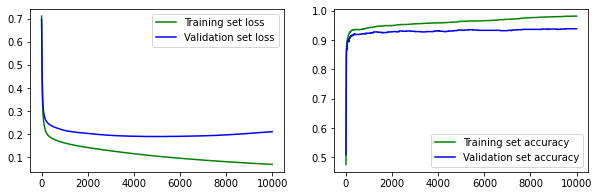

In [ ]:
# define loss function
loss = torch.nn.BCEWithLogitsLoss()
# load dataset
X, T = dataset("spambase.data")
# split dataset
X_train, T_train, X_val, T_val = split_training_data(X, T)
# standardize input data
X_train, X_val = standardize(X_train, X_val)
# instantiate network
network = Network(X.shape[1], 20, 1)
# train network on our data
results = train(X_train, T_train, X_val, T_val, network, loss)
train_loss, train_acc, val_loss, val_acc = results
# plot the results
plot(train_loss, train_acc, val_loss, val_acc)

### Task 9: Categorical Classification

Perform the same tasks with the ``"wine.data"`` dataset for categorical classification. 
How many input and output neurons do we need?
Change the number of input, hidden, and output neurons accordingly.

Select the appropriate loss function for categorical classification.
Which loss function will we need this time?

How many hidden neurons will we need to get 100% training set accuracy?

Loaded dataset with 177 samples


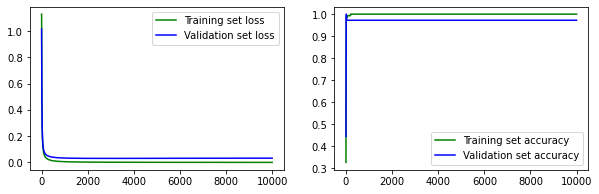

In [ ]:
# define loss function
loss = torch.nn.CrossEntropyLoss()
# load dataset
X, T = dataset("wine.data")
# split dataset
X_train, T_train, X_val, T_val = split_training_data(X, T)
# standardize input data
X_train, X_val = standardize(X_train, X_val)
# instantiate network
network = Network(X.shape[1], 20, 3)

# train network on our data
results = train(X_train, T_train, X_val, T_val, network, loss)
train_loss, train_acc, val_loss, val_acc = results

# plot the results
plot(train_loss, train_acc, val_loss, val_acc)

# Assignment 6: Convolutional Networks

Before we start, we should assure that we have activated CUDA -- otherwise training might take very long.
In Google Colaboratory:

1. Check the options Runtime -> Change Runtime Type on top of the page.
2. In the popup window, select hardware accelerator GPU.

Afterward, the following command should run successfully:

In [ ]:
import torch
if torch.cuda.is_available():
  print("Successfully enabled CUDA processing")
else:
  print("CUDA processing not available. Things will be slow :-(")

Successfully enabled CUDA processing


## Dataset

In PyTorch, a dataset stores a list of input and target tensors $(X^n, T^n)$.
In case of **MNIST** dataset, the inputs are $X^n \in \mathbb R^{28\times28}$ and $T^n \in \{0,\ldots,9\}$.
More precisely, the data in the dataset is provided in form of `PIL.Image.Image`, which represents an image class with some more functionality, and pixel values in range $[0, 255]$.
In order to convert these images into `torch.Tensor`'s in range $[0,1]$, we can use the [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) transform.
Furthermore, in `PyTorch` batches are created from datasets using the [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class.


### Task 1: Dataset Loading


Here, we use the [MNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) of gray images for categorical classification.

Write a function that returns the training and the testing set of MNIST, using the given transform.

In [ ]:
import torch
import torchvision

def datasets(transform):
  trainset = torchvision.datasets.MNIST(transform=transform, root="./data", train=True, download=True)
  testset = torchvision.datasets.MNIST(transform=transform, root="./data", train=False, download=True)

  return trainset, testset

### Test 1: Data Types

When we create the dataset with `transform=None`, all inputs shall be of type `PIL.Image.Image`, and all targets are integral.

In [ ]:
import PIL
trainset, testset = datasets(transform=None)

for x,t in trainset:
  # check datatype of input x
  assert isinstance(x, PIL.Image.Image)
  # check datatype of target t
  assert isinstance(t, int)

100%|██████████| 9912422/9912422 [00:00<00:00, 429421298.15it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 23082258.73it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 152638358.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19360293.46it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Task 2: Data Loaders


Create the dataset with transform `ToTensor`. Create two data loaders, one for the training set and one for the testing set. The training batch size should be $B=64$, for the testing set, you can select any batch size of your choice.


In [ ]:
transform = torchvision.transforms.ToTensor()
trainset, testset = datasets(transform=transform)

B = 64
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=B)
testloader = torch.utils.data.DataLoader(trainset, shuffle=False, batch_size=100)

### Test 2: Batches

Check that all batches generated by the training set data loader have the batch size of $B$ -- except for the last batch, which you need to compute by yourself (you might want to make use of the modulo operator `%`).

Afterward, we check that all inputs and targets are of type `torch.Tensor`, that all input values are in range $[0,1]$ and that all target values are in range $[0,9]$.

In [ ]:
# compute the size of last batch
last_batch = len(trainset) % B

for x,t in trainloader:
  # check datatype, size and content of x
  assert isinstance(x, torch.Tensor)
  assert(torch.all(x >= 0)) and torch.all(x <= 1)  
  assert len(x)==B or len(x) == last_batch

  # check datatype, size and content of t
  assert isinstance(t, torch.Tensor)
  assert(torch.all(t >= 0)) and torch.all(t <= 9)
  assert len(t)==B or len(t) == last_batch

## Networks
As last week, we will rely on [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to create networks with particular lists of consecutive layers.
Particularly, we will investigate two different versions of networks, one fully-connected network and one convolutional network, with the same number of learnable layers.

### Task 3: Fully-Connected Network


Implement a function that returns a three-layer fully-connected network in `pytorch`.
Use $\tanh$ as activation function between the two fully-connected layers, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.
Use the following layers:

1. A [Flatten layer](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) to turn the $28\times28$ pixel image (2D) into a $28\cdot28$ pixel vector (1D).
2. A [fully-connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) with D input neurons and K outputs.
3. A [$\tanh$ activation function](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).
4. A fully-connected layer with K input neurons and K outputs.
5. A $\tanh$ activation function.
6. A fully-connected layer with K input neurons and O outputs.

In [ ]:
def fully_connected(D, K, O):
    return torch.nn.Sequential(
        torch.nn.Flatten(start_dim=1, end_dim=-1),
        torch.nn.Linear(in_features=D, out_features=K, bias=True),
        torch.nn.Tanh(),
        torch.nn.Linear(in_features=K, out_features=K, bias=True),
        torch.nn.Tanh(),
        torch.nn.Linear(in_features=K, out_features=O, bias=True),
    )


### Task 4: Convolutions Output (theoretical question)

Consider the network as defined in Task 5.
Assume that the input is a $28\times28$ grayscale image.
How many hidden neurons do we need in the final fully-connected layer for a given number $Q_2$ of output channels of the second convolution?

We get a picture of 28x28 and we have to give a padding that the matrix will be 32x32. After filtering with stride 1 and 5x5 filter we get the 28x28 matrix. With the kernel size of 2x2 and a stride of 2 we receive a maximum pooling of 14x14. Now we do the same again with Q2 x Q1 x 5 x 5 and after that we get a 7x7 matrix. By flatting it we get 49 values and therefore we need k=49xQ2 hidden neurons.

### Task 5: Convolutional Network

Implement a function that generates a convolutional network with the following layers:

1. A [2D convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with $Q_1$ channels, kernel size $5\times5$, stride 1 and padding 2.
2. A [2D maximum pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) with pooling size $2\times2$ and stride 2.
3. A $\tanh$ activation function.
4. A 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2.
5. A 2D maximum pooling with pooling size $2\times2$ and stride 2.
6. A $\tanh$ activation function.
7. A flattening layer to turn the 3D feature map into a 1D vector.
8. A fully-connected layer with the appropriate number of inputs and $O$ outputs.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class convolutional(nn.Module):
    def __init__(self, Q1, Q2, O):
        super(convolutional, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size=5, stride=1, padding=2)
        self.fc = nn.Linear(Q2 * 7 * 7, O)

    def forward(self, x):
        z = self.pool(F.relu(self.conv1(x)))
        z = self.pool(F.relu(self.conv2(z)))
        z = z.view(-1, self.fc.in_features)
        z = self.fc(z)
        return z


## Network Training
For training and evaluating the network, we rely on standard functionality in PyTorch.
We use the standard [categorical cross-entropy loss](https://pytorch.org/docs/stable/nn.html#loss-functions) together with a [stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer.
For training, we use the batched implementation of the dataset, for which we perform one update step for each training batch.
After having gone through the full training dataset, we compute accuracy and loss values for the testing set (we simply make use of the testing set for validation).


### Task 6: Training and Validation Loop

Implement a function that takes the network, the number of epochs, and the learning rate.
Select the correct loss function for categorical classification and SGD optimizer.
Iterate the following steps for the given number of epochs:

1. Train the network with all batches of the training data.
2. Compute the testing set loss and testing set accuracy.
3. Store both in a vector.

What do we need to take care of?

Finally, return the lists of validation losses and accuracies.

In [ ]:
def train(network, epochs, eta, momentum):
    # select loss function and optimizer
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=network.parameters(), lr=eta, momentum=momentum)

    # instantiate the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = network.to(device)

    # collect loss values and accuracies over the training epochs
    val_loss, val_acc = [], []

    for epoch in range(epochs):
        # train network on training data
        for x, t in trainloader:
            # put data to device
            x, t = x.to(device), t.to(device)
            optimizer.zero_grad()

            # train
            z = network(x)
            J = loss(z, t)
            J.backward()
            optimizer.step()

        # test network on test data
        with torch.no_grad():
            correct = 0
            for x, t in testloader:
                # put data to device
                x, t = x.to(device), t.to(device)

                # compute validation loss
                z = network(x)
                J = loss(z, t)

                # compute validation accuracy
                correct += torch.sum(torch.argmax(z, dim=1) == t).item()
            acc = correct / len(testset)
            val_loss.append(J)
            val_acc.append(acc)

    # return loss and accuracy values
    return val_loss, val_acc


### Task 7: Fully-Connected Training

Create a fully-connected network with $K=100$ hidden and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$, $momentum=0.9$ and store the obtained test losses and accuracies.
Brave people can also train for 100 epochs (which will take up to 30 minutes).

In [ ]:
fc = fully_connected(28*28, 100, 10)
fc_loss, fc_acc = train(fc, 10, 0.01, 0.9)

### Task 8: Convolutional Training


Create a convolutional network with $Q_1=16$ and $Q_2=32$ convolutional channels and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$, momentum $=0.9$ and store the obtained test losses and accuracies.
Again, 100 epochs will take up to 30 minutes.

In [ ]:
cv = convolutional(16, 32, 10)
cv_loss, cv_acc = train(cv, 10, 0.01, 0.9)

### Task 9: Plotting

Plot the two lists of loss values in one plot. Plot the two lists of accuracy values into another plot.

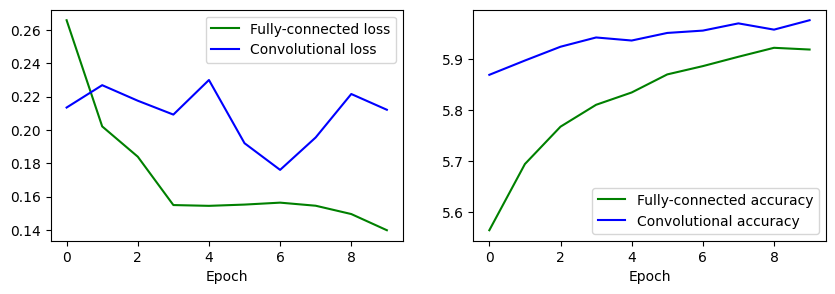

In [ ]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,3))
ax = pyplot.subplot(121)
# plot loss values of FC and CV network over epochs
ax.plot(torch.tensor(fc_loss).cpu(), "g-", label="Fully-connected loss")
ax.plot(torch.tensor(cv_loss).cpu(), "b-", label="Convolutional loss")
ax.set_xlabel("Epoch")
ax.legend()

ax = pyplot.subplot(122)
# plot accuracy values of FC and CV network over epochs
ax.plot(torch.tensor(fc_acc).cpu(), "g-", label="Fully-connected accuracy")
ax.plot(torch.tensor(cv_acc).cpu(), "b-", label="Convolutional accuracy")
ax.set_xlabel("Epoch")
ax.legend()


### Task 10: Learnable Parameters 

Estimate roughly how many learnable parameters the two networks have by analytically computing and adding the number of parameters in each layer.

Fully-connected Network:
- first fully-connected layer: ...
- second fully-connected layer: ...
- third fully-connected layer: ...
- total: ...

Convolutional Network:
- first convolutional layer: ...
- second convolutional layer: ...
- fully-connected layer: ...
- total: ...



Now, compute the number of parameters in the networks by summing the number of parameters in each layer using `pytorch` functionality.
You can use the `numel()` function from a `torch.Tensor` to provide the number of (learnable) parameters stored in a tensor.
How do you obtain this list of all learnable parameters from a `pytorch` [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)?

In [ ]:
def parameter_count(network):
  return sum(p.numel() for p in network.parameters())

print("Fully-connected Network:", parameter_count(fc))
print("Convolutional Network:", parameter_count(cv))

Fully-connected Network: 89610
Convolutional Network: 28938


# Assignment 7: Transfer Learning


The goal of this exercise is to learn how to use pre-trained networks in transfer learning tasks.
We will make use of networks trained on ImageNet, and apply them to related problems, i.e., the classification of $10$ objects not contained in ImageNet.

## Dataset

For this exercise we use the  [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset that can be downloaded from the official website [here]({https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz}).
The dataset contains $60000$ color images of pixels size $32\times 32$ in $10$ classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck, with $6000$ images per class.

### Task 1: Data Transformation

We need to instantiate a proper `torchvision.transform` instance to create the same input structure as used for training our network.
We need to combine 4 transforms, which can be compiled from the PyTorch website: https://pytorch.org/vision/stable/models.html

1. We need to resize the image such that the shorter side has size 256.
2. We need to take the center crop of size $224\times224$ from the image.
3. We need to convert the image into a tensor (including pixel values scaling)
4. We need to normalize the pixel values with mean $(0.485, 0.456, 0.406)$ and standard deviation $(0.229, 0.224, 0.225)$.

Since we will use networks pre-trained on ImageNet, we need to perform the exact same transform as used for ImageNet testing.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet101
import torchvision
from tqdm import tqdm

imagenet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


### Task 2: Dataset Loading

We here use the [torchvision.datasets.CIFAR10](https://pytorch.org/vision/0.12/generated/torchvision.datasets.CIFAR10.html) dataset interface for processing images. 
You can use the `train` argument or flag to distinguish between training and test set.

This task consists of two parts:

1. Create two datasets, one for the training set, one for the test set. Use the transform defined above.
2. Once the datasets are created, create two data loaders, one for training set, one for test set. Use a proper value of the batch-size $B$.

In [ ]:
trainset = torchvision.datasets.CIFAR10(
  root = "./data",
  train=True, download=True, transform=imagenet_transform
)

testset = torchvision.datasets.CIFAR10(
  root = "./data",
  train=False, download=True, transform=imagenet_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
B = 64
trainloader = torch.utils.data.DataLoader(dataset = trainset, batch_size=B)
testloader = torch.utils.data.DataLoader(dataset = testset, batch_size=B)

### Test 1: Data Size and Types

We check that all input images are `torch.tensors` of size $3\times224\times224$ and of type `torch.float` and that all labels are of type `int`.

Note: the sanity check is only performed on the test set.

In [ ]:
for x, t in testset:
  assert isinstance(x, torch.Tensor)
  assert isinstance(t, int)
  assert x.shape==(3,224,224)
  assert x.dtype==torch.float

## Deep Feature Extraction

We will use a pre-trained network available in `PyTorch`. 
Particularly, we will use a ResNet-50 architecture, but other architectures can also be tested. 
Fortunately, PyTorch provides simple interfaces to obtain pre-trained models, e.g., using the `torchvision.models.resnet50` interface function.

In order to use the networks in a different dataset, we need to change their outputs. 
There are several possibilities on how to achieve that, and you have the freedom to choose. 

For your reference, the implementation of the `forward` function of ResNet networks (including ResNet-50) can be found here: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L266

You can also check if other networks perform better, for example, deeper ResNet topologies.
Be aware that the strategy to replace the last fully-connected layer might not work in other network topologies, only in residual networks.

### Task 3: Pre-trained Network Instantiation

Instantiate two pre-trained networks of type ResNet-50.

1. Freeze the feature layers of the first network.

Note: Make use the `old TorchVision Interface` to load your pre-trained network. Here is the link: https://pytorch.org/vision/0.12/models.html 

In [ ]:
# instantiate the first pre-trained resnet 50 network
network_1 = torchvision.models.resnet50(pretrained=True)
# Make sure to freeze all the layers of the network.
network_1.requires_grad_(False)

# instantiate the second pre-trained resnet 50 network (optinally)
network_2 = torchvision.models.resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Task 4: Network Implementation

We want to modify the network such that we extract the logits for the 10 classes from CIFAR-10 from the last fully-connected layer of the network.

Implement a function that:
1. Replaces the current last linear layer of the pre-trained network with a new linear layer that has $O$ units ($O$ represents the number of classes in our dataset).
2. Initialize the weights of the new linear layer using Xavier's method **(Optional)**.

Note: Use `torch.nn.init.xavier_uniform_` function to initialize the weights of the new linear layer.

In [ ]:
def replace_last_layer(network, O=10):
  # replace the last linear layer with the new layer
  network.fc = torch.nn.Linear(network.fc.in_features, O)

  # initialize weights xavier uniform
  torch.nn.init.xavier_uniform_(network.fc.weight)
  
  return network

### Test 2: Last layer dimensions

This test ensures that the function return a network having the correct number of input and output units in the last layer.

In [ ]:
O = 10
for network in (network_1, network_2):
    new_model = replace_last_layer(network_1, O=O)
    assert new_model.fc.out_features == O
    assert new_model.fc.in_features == 2048

## Network Training
Implement a function that takes all necessary parameters to run a training on a given dataset. 
Select the optimizer to be `torch.optim.SGD` and `torch.nn.CrossEntropyLoss` as the loss function. 
The test set will be used as the validation set.

### Task 5: Training and Evaluation Loop

Implement a training loop over a specific number of epochs (10) with a learning rate of $\eta=0.001$ and momentum of $\mu = 0.9$. 
Make sure that you train on the training data only, and `not` on the validation data.
In each loop, compute and print the training loss, training accuracy, validation loss and validation accuracy. 

In [ ]:
def accuracy(Z, T):
  # check if we have binary or categorical classification
  # for binary classification, we will have a two-dimensional target tensor
  if len(T.shape) == 2:
    # binary classification
    # If z is equal or larger than the threshold 0.5, then we predict 1, otherwise 0 
    # we use the .float() function to convert the boolean to a float
    # then we compare the prediction with the target and compute the mean
    
    # ??? our data is binary between 0 and 1, so why do you use 0 as threshold ???
    # So only if we use sigmoid activation function for binary or softmax for multi-class
    # after the last layer, we need to use 0.5 as threshold
    return torch.mean(((Z>=0).float() == T).float())

  else:
    # categorical classification
    # the argmax function returns the index of the maximum value
    # we use the .float() function to convert the boolean to a float
    # then we compare the prediction with the target and compute the mean
    # return torch.mean((torch.argmax(Z, dim=1).float() == T).float())
    
    # Y is the index of the maximum value in Z
    Y = torch.argmax(Z, dim=1)
    return torch.mean((Y == T).float())

In [ ]:
def train_eval(network, epochs:int = 10, lr:float = 0.001,  µ:float = 0.9):
    
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(network.parameters(), 
                                lr=lr, 
                                momentum=µ)

    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    
    # instantiate the correct device
    device = torch.device("cuda")
    network = network.to(device)


    for epoch in tqdm(range(epochs)):
        batch_train_loss, batch_train_acc = [], []
        # train network on training data
        for x,t in trainloader:
        # put data to device
            x, t = x.to(device), t.to(device)
            # train
            optimizer.zero_grad()
            # train on training set
            # ... compute network output on training data
            Z = network(x)
            # ... compute loss from network output and target data
            loss_ = loss(Z, t)
            loss_.backward()
            # ... perform parameter update
            optimizer.step()
            # ... remember loss and accuracy
            batch_train_loss.append(loss_.item())
            batch_train_acc.append(accuracy(Z, t).item())
        
    # careful calculate loss and accuracy averaged over batches
    train_loss.append(sum(batch_train_loss) / len(batch_train_loss))
    # ... compute validation set accuracy
    train_acc.append(sum(batch_train_acc) / len(batch_train_acc))

        
    with torch.no_grad():
        batch_val_loss, batch_val_acc = [], []
        for x,t in testloader:
            # put data to device
            x, t = x.to(device), t.to(device)
            # compute validation loss
            Z = network(x)
            # ... compute loss from network output and target data
            loss_ = loss(Z, t)
            # ... remember loss
            batch_val_loss.append(loss_.item())
            # ... compute validation set accuracy
            batch_val_acc.append(accuracy(Z, t).item())
            
        # careful calculate loss and accuracy averaged over batches
        val_loss.append(sum(batch_val_loss) / len(batch_val_loss))
        # ... compute validation set accuracy
        val_acc.append(sum(batch_val_acc) / len(batch_val_acc))


    # return loss and accuracy values
    return train_loss, train_acc, val_loss, val_acc

### Task 6: Network Fine-Tuning with Frozen Layers

Create a network that has feature layers frozen with $10$ output units. 
Fine-tune the created network on our CIFAR-10 data using the previous function.

In [ ]:
network_with_frozen_layers = replace_last_layer(network_1, O=O)
train_eval(network = network_with_frozen_layers, epochs=10, lr=0.001, µ=0.9)

100%|██████████| 10/10 [25:01<00:00, 150.20s/it]


([0.6123228761012597],
 [0.7928588554987213],
 [0.6514452972989173],
 [0.7741839171974523])

### Task 7 (Optional): Network Fine-Tuning without Frozen Layers 

Create a network from the second pre-trained network with $10$ output units. 
Fine-tune the created network on our CIFAR-10.

Note:

  * The fine-tuning of the network can take a long time when the layers are not frozen.

In [ ]:
network_normal = replace_last_layer(network_2, O=O)
train_eval(network = network_normal, epochs=10, lr=0.001, µ=0.9)

100%|██████████| 10/10 [41:22<00:00, 248.27s/it]


([0.0006658388263582552], [1.0], [0.2124734493743652], [0.9460589171974523])

## Plotting

Finally, we want to plot the confusion matrix of the test set.
For this, we need to compute the predictions for all of our test samples, and the list of target values.
Finally, we can make use of the `sklearn.metrics.confusion_matrix` to compute the confusion matrix.
You can utilize `sklearn.metrics.ConfusionMatrixDisplay` for displaying the confusion matrix, or `pyplot.imshow` and adding the according labels.

Note:

  * The documentation for the confusion matrix can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
  * The interface and an example for the `ConfusionMatrixDisplay` can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

### Task 8: Confusion Matrix Plotting

Plot the confusion matrix for the fine-tuned network with frozen layers.
Optionally, also plot the confusion matrix for the second fine-tuned network.

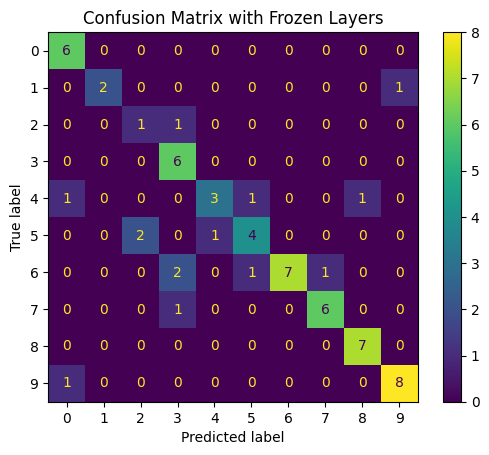

Ellipsis

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda")

# compute predictions and collect targets
for batch_idx, (x, t) in enumerate(testloader):
    # put data to device
    x, t = x.to(device), t.to(device)
    # compute predictions
    Z = network_with_frozen_layers(x)
    # collect targets
    targets = t.cpu()
    predictions = torch.argmax(Z, dim=1).cpu()
    break
    
# compute confusion matrix
matrix = confusion_matrix(targets, predictions)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=range(10))
disp.plot()
plt.title("Confusion Matrix with Frozen Layers")
plt.show()

# add axis labels if required
...

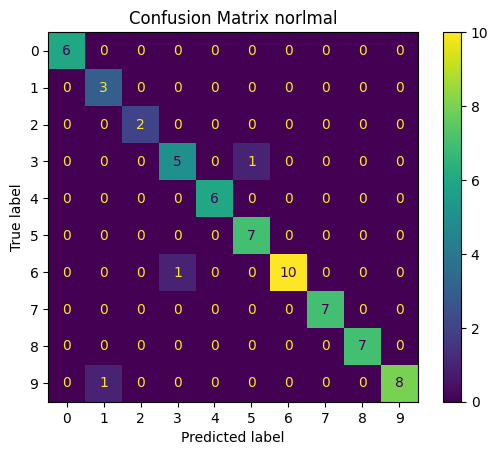

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda")

# compute predictions and collect targets
for batch_idx, (x, t) in enumerate(testloader):
    # put data to device
    x, t = x.to(device), t.to(device)
    # compute predictions
    Z = network_normal(x)
    # collect targets
    targets = t.cpu()
    predictions = torch.argmax(Z, dim=1).cpu()
    break
    
# compute confusion matrix
matrix = confusion_matrix(targets, predictions)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=range(10))
disp.plot()
plt.title("Confusion Matrix normal")
plt.show()


# Assignment 8: Open-Set Classification

In this assignment, we develop a network that is capable of correctly classifying known classes while at the same time rejecting unknown samples that occur during inference time.
To showcase the capability, we make use of the MNIST dataset that we artificially split into known, negative and unknown classes; this allows us to train a network on the data without requiring too expensive hardware.
Known and negative classes are used during training, and unknown classes appear only in the testing set.

## Dataset
We split the MNIST dataset into 4 known classes, 4 negative classes (used for training) and 2 unknown classes (used only for testing).
While several splits might be possible, here we restrict to the following:
* Known class indexes: (1, 4, 7, 9)
* Negative class indexes: (0, 2, 3, 5)
* Unknown class indexes: (6,8)

Please note that, in PyTorch, class indexing starts at 0 (other than in the lecture where class indexing starts at 1).

We rely on the `torchvision.datasets.MNIST` implementation of the MNIST dataset, which we adapt to our needs.
The constructor of our Dataset class takes one parameter that defines the purpose of this dataset (`"train", "validation", "test"`).
The `"train"` partition uses the training samples of the *known* and the *negative* classes.
The `"validation"` partition uses the test samples of the *known* and the *negative* classes.
Finally, the `"test"` partition uses the test samples of the *known* and the *unknown* classes.

In our implementation of the Dataset class, we need to implement two functions.
* First, the constructor `__init__(self, purpose)` selects the data based on our purpose. 
* Second, the index function `__getitem__(self, n)` returns a pair $(X^n, \vec t{\,}^{n})$ for the sample with the index $n$, where $X \in \mathbb R^{1\times28\times28}$ with values in range $[0,1]$ and $\vec t \in \mathbb R^{O}$, see below.

Since our loss function (cf. Task 5) requires our target vectors to be in vector format, we need to convert the target index $\tau^n$ into its vector representation $\vec t{\,}^n$.
Particularly, we need to provide the following target vectors: 

<center> 

 $\tau^n = 1 : \vec t{\,}^n = (1,0,0,0)$ 

 $\tau^n = 4 : \vec t{\,}^n = (0,1,0,0)$ 
 
 $\tau^n = 7 : \vec t{\,}^n = (0,0,1,0)$
 
 $\tau^n = 9 : \vec t{\,}^n = (0,0,0,1)$

 else: $\vec t{\,}^n = (\frac14,\frac14,\frac14,\frac14)$

</center>


### Task 1: Target Vectors

Implement a function that generates a target vector for any of the ten different classes according to above description. The return value should be a `torch.tensor` of type float.



In [ ]:
import torch
import torchvision
import numpy as np

# define the three types of classes
known_classes = (1,4,7,9)
negative_classes = (0,2,3,5)
unknown_classes = (6, 8)
O = len(known_classes)

# define one-hot vectors
labels_known = [torch.tensor([1,0,0,0]), torch.tensor([0,1,0,0]), torch.tensor([0,0,1,0]), torch.tensor([0,0,0,1])]
label_unknown = [torch.tensor([0.25,0.25,0.25,0.25])]

def target_vector(index):
  # select correct one-hot vector for known classes, and the 1/O-vectors for unknown classes
  if index in known_classes:
    return labels_known[known_classes.index(index)]
  if index in negative_classes or unknown_classes:
    return label_unknown[0]

c:\Users\Schoggi\miniconda3\envs\pydml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Test 1: Check your Target Vectors

Test that your target vectors are correct, for all tpyes of known and unknown samples.


In [ ]:
# check that the target vectors for known classes are correct
for index in known_classes:
  t = target_vector(index)
  print(index, t) 
  assert max(t) == 1
  assert sum(t) == 1

# check that the target vectors for negative and unknown classes are correct
for index in negative_classes + unknown_classes:
  t = target_vector(index)
  print(index, t)
  assert max(t) == 0.25
  assert sum(t) == 1

1 tensor([1, 0, 0, 0])
4 tensor([0, 1, 0, 0])
7 tensor([0, 0, 1, 0])
9 tensor([0, 0, 0, 1])
0 tensor([0.2500, 0.2500, 0.2500, 0.2500])
2 tensor([0.2500, 0.2500, 0.2500, 0.2500])
3 tensor([0.2500, 0.2500, 0.2500, 0.2500])
5 tensor([0.2500, 0.2500, 0.2500, 0.2500])
6 tensor([0.2500, 0.2500, 0.2500, 0.2500])
8 tensor([0.2500, 0.2500, 0.2500, 0.2500])


### Tasks 2 and 3: Dataset Construction and Dataset Item Selection

Write a dataset class that derives from `torchvision.datasets.MNIST` in `PyTorch` and adapts some parts of it. 
In the constructor, make sure that you let `PyTorch` load the dataset by calling the base class constructor `super` with the desired parameters. Afterward, the `self.data` and `self.targets` are populated with all samples and target indexes.
From these, we need to sub-select the samples that fit our current `purpose` and store them back to `self.data` and `self.targets`.

Second, we need to implement the index function of our dataset, where we need to return both the image and the target vector.
The images in `self.data` were originally stored as `uint8` values in the dimension $\mathbb N^{N\times28\times28}$ with values in $[0, 255]$.
The targets in `self.targets` were originally stored as class indexes in the dimension $\mathbb N^N$. Make sure that you return both in the desired format.

Notes:

* Since Jupyter Notebook does not allow splitting classes over several code boxes, the two tasks are required to be solved in the same code box.
* **The definition below is just one possibility.** There are many ways to implement this dataset interface. 
* With a clever implementation of the constructor, there is no need to overwrite the `__getitem__(self,index)` function.
* Depending on your implementation, you might also need to overwrite the `__len__(self)` function.

In [ ]:
class DataSet(torchvision.datasets.MNIST):
  def __init__(self, purpose="train"):
    # call base class constructor to handle the data loading
    # make sure that you get the correct part of the data based on the purpose
    super(DataSet, self).__init__(
      root='data',
      train=(purpose=="train"),
      download=True,
      transform=torchvision.transforms.ToTensor()
    )

    # select the valid classes based on the current purpose
    if purpose == "train":
      self.classes = known_classes + negative_classes
    elif purpose == "valid":
      self.classes = known_classes + negative_classes
    elif purpose == "test":
      self.classes = known_classes + unknown_classes
    # check if one element of the list is in another list
    mask = np.column_stack([self.targets == i for i in self.classes]).any(axis=1)
    # sub-select the data of valid classes
    self.data = self.data[mask]
    # select the targets of valid classes
    self.targets = self.targets[mask]
  

  def __getitem__(self, index):
    # perform appropriate actions on the data and the targets
    # the format of data should be in [0, 1]
    (input,target) = super().__getitem__(index)
    target = target_vector(target)
    return input, target

In [ ]:
# instantiate the training dataset
train_set = DataSet(purpose="train")

100%|██████████| 9912422/9912422 [00:00<00:00, 38149574.28it/s]


Extracting data\DataSet\raw\train-images-idx3-ubyte.gz to data\DataSet\raw



100%|██████████| 28881/28881 [00:00<00:00, 57793747.05it/s]


Extracting data\DataSet\raw\train-labels-idx1-ubyte.gz to data\DataSet\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6247389.48it/s]


Extracting data\DataSet\raw\t10k-images-idx3-ubyte.gz to data\DataSet\raw



100%|██████████| 4542/4542 [00:00<00:00, 9058739.31it/s]

Extracting data\DataSet\raw\t10k-labels-idx1-ubyte.gz to data\DataSet\raw



### Test 2: Data Sets


Instantiate the training dataset.
Implement a data loader for the training dataset with a batch size of 64.
Assure that all inputs are of the desired type and shape.
Assert that the target values are in the correct format, and the sum of the target values per sample is one.


In [ ]:
# instantiate the training dataset
train_set = DataSet(purpose="train")
train_loader = torch.utils.data.DataLoader(train_set, 64, shuffle=True)

# assert that we have not filtered out all samples
assert len(train_set)!= 60000 and len(train_set)== 48231

# check the batch and assert valid data and sizes
for x,t in train_loader:
  assert len(x) <= 64
  assert len(t) == len(x)
  assert torch.all(torch.sum(t, axis = 1) == 1)
  assert x.shape == torch.Size([x.shape[0], 1, 28, 28])
  assert x.dtype == torch.float32
  assert torch.max(x) <= 1

### Task 4: Utility Function

Implement a function that splits a batch of samples into known and negative/unknown parts. For the known parts, also provide the target vectors.
How can we know which of the data samples are known samples, and which are negative/unknown?

This function needs to return three elements:
* First, the samples from the batch that belong to known classes.
* Second, the target vectors that belong to the known classes.
* Finally, the samples from the batch that belong to negative/unknown classes.

In [ ]:
def split_known_unknown(batch, targets):
  # select the indexes at which known and unknown samples exist
  known = torch.any(targets == 1, dim=1)
  unknown = torch.all(targets == 1/4, dim=1)
  # return the known samples, the targets of the known samples, as well as the unknown samples
  return batch[known], targets[known], batch[unknown]

## Loss Function and Confidence

We write our own PyTorch implementation of our loss function.
Particularly, we implement a manual way to define the derivative of our loss function via `torch.autograd.Function`, which allows us to define the forward and backward pass on our own.
For this purpose, we need to implement two `static` functions in our loss.
The function `forward(ctx, logits, targets)` is required to compute the loss value and allows us to store some variables in the context of the backward pass.
The `backward(ctx, result)` provides us with the result of the forward function (the loss value) as well as the context with our stored variables.
Here, we need to compute the derivative of the loss with respect to both of the inputs to the forward function (which might look a bit confusing), i.e.,$\frac{\partial \mathbf{J}^{CCE}}{\partial \mathbf{Z}}$ and $\frac{\partial \mathbf{J}^{CCE}}{\partial \mathbf{T}}$.
Since the latter is not required, we can also simply return `None` for the second derivative.

<font color=#FF000>Hint: if you think the implementation of loss function is too hard, you can also cross-entropy as your loss function (**since PyTorch version 1.11**).</font>

### Task 5: Loss Function Implementation

Implement a `torch.autograd.Function` class for the adapted SoftMax function according to the equations provided in the lecture.
You might want to compute the log of the network output $\ln y_o$ from the logits $z_o$ via `torch.nn.functional.log_softmax`.
Store all the data required for the backward pass in the context during `forward`, and extract these from the context during `backward`.

In [ ]:
class AdaptedSoftMax(torch.autograd.Function):

  # implement the forward propagation
  ### ctx is a context object that can be used to stash information for backward computation
  @staticmethod
  def forward(ctx, logits, targets):
    # compute the log probabilities via log_softmax
    log_probs = torch.nn.functional.log_softmax(logits, dim=1)
    # save required values for backward pass
    ctx.save_for_backward(logits, targets)
    # compute loss
    loss = -targets * log_probs
    return torch.sum(loss)

  # implement Jacobian
  @staticmethod
  def backward(ctx, result):
    # get results stored from forward pass
    logits, targets = ctx.saved_tensors
    # compute derivative of loss w.r.t. the logits
    # y = torch.nn.functional.cross_entropy(logits, targets)
    # dJ_dy = torch.autograd.grad(y, logits)[0]
    #?? 
    dJ_dy = torch.exp(logits) - targets
    # return the derivatives; none for derivative for the targets
    return dJ_dy, None

# DO NOT REMOVE!
# here we set the adapted softmax function to be used later
adapted_softmax = AdaptedSoftMax.apply

### Task 5a: Alternative Loss Function

In case the loss function is too difficult to implement, you can also choose to rely on PyTorch's automatic gradient computation and simply define your loss function without the backward pass.

In this case, we only need to define the forward pass. A simple function `adapted_softmax(logits, targets)` is sufficient.

You can implement any variant of the categorical cross-entropy loss function on top of SoftMax activations as defined in the lecture.


In [ ]:
def adapted_softmax_alt(logits, targets):
  # compute cross-entropy loss on top of softmax values of the logits
  loss = torch.nn.functional.cross_entropy(logits, targets)
  return loss

### Task 6: Confidence Evaluation


Implement a function to compute the confidence value for a given batch of samples. 
Compute Softmax confidence and split these confidences between known and negative/unknown classes. 
For samples from known classes, sum up the SoftMax confidences of the correct class. 
For negative/unknown samples, sum 1 minus the maximum confidence for any of the known classes; also apply the $\frac1O$ correction for the minimum possible SoftMax confidence.

In [ ]:
def confidence(logits, targets):
  # comupte softmax confidences
  conf = torch.nn.functional.softmax(logits, dim=1)
  # split between known and unknown
  known = torch.any(targets == 1, dim=1)
  unknown = torch.all(targets == 1/4, dim=1)
  # compute confidence score for known targets
  conf_known = torch.sum(conf[known] * targets[known])
  # compute confidence score for unknown targets
  ### max_unknown = torch.max(unknown, dim=1).values
  ### conf_unknown = 1 - max_unknown
  ### conf_unknown = conf_unknown * (1 - 1/O)
  conf_unknown = torch.sum(conf[unknown] * targets[unknown]) * 4
  return conf_known + conf_unknown

### Test 3: Check Confidence Implementation

Test that your confidence implementation does what it is supposed to do.

Note that confidence values should always be between 0 and 1, other values indicate an issue in the implementation.

In [ ]:
# select good logit vectors for known and unknown classes
logits = torch.tensor([[10., 0., 0., 0.], [-10., 0, -10., -10.], [0.,0.,0.,0.]])
# select the according target vectors for these classes
targets = torch.stack([target_vector(known_classes[0]), target_vector(known_classes[1]), target_vector(negative_classes[0])])

# the confidence should be close to 1 for all cases
assert 3 - confidence(logits, targets) < 1e-3

## Network and Training

We make use of the same convolutional network as utilized in Assignment 6, to which we append a final fully-connected layer with $K$ inputs and $O$ outputs.
Additionally, we replace the $\tanh$ activation function with the better-performing ReLU function.

The topology can be found in the following:
1. 2D convolutional layer with $Q_1$ channels, kernel size $5\times5$, stride 1 and padding 2
2. 2D maximum pooling layer with kernel size $2\times2$ and stride 2
3. Activation function ReLU
4. 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2
5. 2D maximum pooling layer with kernel size $2\times2$ and stride 2
6. Activation function ReLU
7. Flatten layer to convert the convolution output into a vector
8. Fully-connected layer with the correct number of inputs and $K$ outputs
9. Fully-connected layer with $K$ inputs and $O$ outputs

However, instead of relying on the `torch.nn.Sequential` class, we need to define our own network class, which we need to derive from `torch.nn.Module` -- since our network has two outputs.
We basically need to implement two methods in our network.
The constructor `__init__(self, Q1, Q2, K)` needs to call the base class constructor and initialize all required layers of our network.
The `forward(self, x)` function then passes the input through all of our layers and returns both the deep features (extracted at the first fully-connected layer) and the logits (extracted from the second fully-connected layer).


### Task 7: Network Definition

We define our own small-scale network to classify known and unknown samples for MNIST.
We basically use the same convolutional network as in Assignment 6, with some small adaptations.
However, this time we need to implement our own network model since we need to modify our network output.

Implement a network class, including the layers as provided above.
Implement both the constructor and the forward function.
Instantiate the network with $Q_1=16, Q_2=32, K=20, O=4$.


In [ ]:
class Network (torch.nn.Module):
  def __init__(self, Q1, Q2, K, O):
    # call base class constrcutor
    super(Network,self).__init__()
    # define convolutional layers
    self.conv1 = torch.nn.Conv2d(1, Q1, kernel_size= [5,5], stride=1, padding=2)
    self.conv2 = torch.nn.Conv2d(Q1, Q2, kernel_size= [5,5], stride=1, padding=2)
    # pooling and activation functions will be re-used for the different stages
    self.pool = torch.nn.MaxPool2d(kernel_size=[2,2], stride=2)
    self.act = torch.nn.ReLU()
    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    # ?? how do I know the size of the input to the first fully-connected layer?
    
    self.fc1 = torch.nn.Linear(Q2 * 7 * 7, K)
    self.fc2 = torch.nn.Linear(K, O)
  
  def forward(self,x):
    # compute first layer of convolution, pooling and activation
    a = self.act(self.pool(self.conv1(x)))
    # compute second layer of convolution, pooling and activation
    a = self.act(self.pool(self.conv2(a)))
    # get the deep features as the output of the first fully-connected layer
    # ?? why do I flatten before input to the first fully-connected layer?
    deep_features = self.act(self.fc1(self.flatten(a)))
    # get the logits as the output of the second fully-connected layer
    logits = self.fc2(deep_features)
    # return both the logits and the deep features
    return logits, deep_features

# run on cuda device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# create network with 20 hidden neurons in FC layer
network = Network(Q1=16, Q2=32, K= 20, O= 4).to(device)

### Task 8: Training Loop

Instantiate the training and validation set and according data loaders.
Instantiate an SGD optimizer with an appropriate learning rate (the optimal learning rate might depend on your loss function implementation and can vary between 0.1 and 0.00001).
Implement the training and validation loop for 10 epochs (you can also train for 100 epochs if you want).
Compute the training set confidence during the epoch.
At the end of each epoch, also compute the validation set confidence measure.
Print both the training set and validation set confidence scores to the console.


In [ ]:
# SGD optimizer with appropriate learning rate
optimizer = torch.optim.SGD(network.parameters(),lr=0.001, momentum=0.9)
batch_size=64

# instantiate the training dataset and data loader
train_set = DataSet(purpose='train')
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# validation set and data loader
validation_set = DataSet(purpose='valid')
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size)

for epoch in range(10): # or 100
  # evaluate average confidence for training and validation set
  train_conf = validation_conf = 0.

  for x,t in train_loader:
    # extract logits (and deep features) from network
    optimizer.zero_grad()
    # extract logits (and deep features) from network
    logits, deep_feature = network(x.to(device))
    # compute our loss
    J = AdaptedSoftMax.apply(logits, t.to(device))
    #J = adapted_softmax_alt(logits, t.to(device))
    # J = torch.mean(J)
    J.backward()
    # perform weight update
    optimizer.step()

    # compute training confidence
    with torch.no_grad():
      train_conf += confidence(logits, t.to(device))

  # compute validation comfidence
  with torch.no_grad():
    for x,t in validation_loader:
      # extract logits (and deep features)
      logits, deep_feature = network(x.to(device))
      # compute validation confidence
      validation_conf += confidence(logits, t.to(device))

  # print average confidence for training and validation
  print(f"\rEpoch {epoch}; train: {train_conf/len(train_set):1.5f}, val: {validation_conf/len(validation_set):1.5f}")

Epoch 0; train: 0.93643, val: 0.97418
Epoch 1; train: 0.98217, val: 0.98206
Epoch 2; train: 0.98694, val: 0.98431
Epoch 3; train: 0.98902, val: 0.99117
Epoch 4; train: 0.99082, val: 0.98743
Epoch 5; train: 0.99159, val: 0.99173
Epoch 6; train: 0.99297, val: 0.99153
Epoch 7; train: 0.99339, val: 0.99221
Epoch 8; train: 0.99405, val: 0.99285
Epoch 9; train: 0.99478, val: 0.99274


## Evaluation

For evaluation, we test two different things.
First, we check whether our intuition is correct, and the training helps reduce the deep feature magnitudes of unknown samples while maintaining magnitudes for known samples.
It is also interesting to see whether there is a difference between samples of the negative classes that were seen during training, and unknown classes that were not.
For this purpose, we extract the deep features for the validation and test sets, compute their magnitudes, and plot them in a histogram.

The second evaluation computes Correct Classification Rates (CCR) and False Positive Rates (FPR) for a given confidence threshold $\zeta=0.98$ (based on your training results, you might want to vary this threshold).
For the known samples, we compute how often the correct class was classified with a confidence over threshold.
For unknown samples, we assess how often one of the known classes was predicted with a confidence larger than $\zeta$.



### Task 9: Feature Magnitude Plot

Extract deep features for validation and test set samples and compute their magnitudes. Split them into known, negative (validation set), and unknown (test set). Plot a histogram for each of the three types of samples.
Note that the minimum magnitude is 0, and the maximum magnitude can depend on your network training success.

Text(0, 0.5, 'Density')

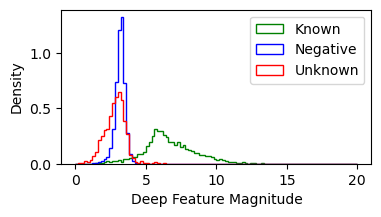

In [ ]:
# instantiate test set and according data loader
test_set = DataSet(purpose='test')
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# collect feature magnitudes for 
known, negative, unknown = [], [], []

with torch.no_grad():
  # extract deep features magnitudes for validation set
  for x,t in validation_loader:
    # extract deep features (and logits)
    logits, deep_features = network(x.to(device))
    # compute norms
    norms = torch.norm(deep_features, dim=1)
    # split between known and negative
    batch_known, targets_known, batch_unknown = split_known_unknown(norms, t)
    # collect norms of known samples
    known.extend(batch_known.tolist())
    # collect norms of negative samples
    negative.extend(batch_unknown.tolist())

  for x,t in test_loader:
    # extract deep features (and logits)
    logits, deep_features = network(x.to(device))
    # compute norms
    norms = torch.norm(deep_features, dim=1)
    # split between known and unknown
    batch_known, targets_known, batch_unknown = split_known_unknown(norms, t)
    # collect norms of known samples
    known.extend(batch_known.tolist())
    # collect norms of unknown samples
    unknown.extend(batch_unknown.tolist())

# plot the norms as histograms
from matplotlib import pyplot
pyplot.figure(figsize=(4,2))

# keep the same maximum magnitude
max_mag = 20
# plot the three histograms
pyplot.hist(known, bins=100, range=(0,max_mag), density=True, color="g", histtype="step", label="Known")
pyplot.hist(negative, bins=100, range=(0,max_mag), density=True, color="b", histtype="step", label="Negative")
pyplot.hist(unknown, bins=100, range=(0,max_mag), density=True, color="r", histtype="step", label="Unknown")

# beautify plot
pyplot.legend()
pyplot.xlabel("Deep Feature Magnitude")
pyplot.ylabel("Density")

### Task 10: Classification Evaluation

For a fixed threshold of $\zeta=0.98$, compute CCR and FPR for the test set.
A well-trained network can achieve a CCR of > 90% for an FPR < 10%.
You might need to vary the threshold.

In [ ]:
zeta = 0.98

# count the correctly classified and the total number of known samples
correct = known = 0
# count the incorrectly classified and the total number of unknown samples
false = unknown = 0

with torch.no_grad():
  for x,t in test_loader:
    # extract logits (and deep features)
    logits, deep_features = network(x.to(device))
    # compute softmax confidences
    confidences = torch.softmax(logits, dim=1)
    # split between known and unknown
    batch_known, targets_known, batch_unknown = split_known_unknown(confidences[:,0], t)

    # compute number of correctly classified knowns above threshold
    correct += batch_known [batch_known > zeta].size(0)
    known += 

    # compute number of incorrectly accepted known samples
    false += ...
    unknown += ...

# print both rates
print (f"CCR: {correct} of {known} = {correct/known*100:2.2f}%")
print (f"FPR: {false} of {unknown} = {false/unknown*100:2.2f}%")

SyntaxError: invalid syntax (1541997817.py, line 19)

# Assignment 9: Convolutional Auto-Encoder

In this assignment, we show that it is possible to learn from unlabeled data using a convolutional auto-encoder network. 
The task is to reduce (a noisy version of) an image of the handwritten digits of MNIST into a deep feature representation, without making use of their labels, and reconstruct the sample from that representation.

For this purpose, we implement a convolutional auto-encoder and a denoising auto-encoder that learn a $K=10$-dimensional deep feature representation of each image, and uses this representation to reconstruct images to the original size of $28\times28$ pixels.
We show that such a network can be used to denoise images.

## Dataset

We will make use of the default implementation of the `torchvision.datasets.MNIST` dataset. 
MNIST has 10 labels of digit images.
However, besides the last task, we do not make use of the labels of the dataset, but we only utilize the images.
We instantiate the training and test sets of MNIST -- again we will use the test set for validation purposes.

### Task 1: Datasets

Instantiate the training and validation datasets of MNIST, i.e., split the training and validation sets, and make use of data loaders.
Select a simple `ToTensor` transform.
Instantiate a training data loader using a batch size of $B=32$, and a validation data loader with 100 samples in a batch.

In [ ]:
import torch
import torchvision
import numpy as np

B = 32 # batch size

# training set and data loader
train_set = trainset = torchvision.datasets.MNIST(
  root = "./data",
  train=True, download=True, transform=torchvision.transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size=B)

# validation set and data loader
validation_set = testset = torchvision.datasets.MNIST(
  root = "./data",
  train=False, download=True, transform=torchvision.transforms.ToTensor()
)
validation_loader = torch.utils.data.DataLoader(dataset = validation_set, batch_size=B)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Task 2: Random Noise

Implement a function to generate noisy images by adding a uniform noise to the clean images:

$$\mathbf X_{\mathrm{noise}} = \mathbf X + \alpha \mathbf U^{D\times E}$$ 

where $\mathbf U$ is a tensor with entries generated from a uniform distribution between $-1$ and $1$. 
$D=E=28$ are the width and the height of the original image. 
To represent actual images, we will restrict the pixel values of $\mathbf X_{\mathrm{noise}}$ to be in the range $[0,1]$ by clipping any value that is outside that range.

Note that this function will also be used with batches of samples.

In [ ]:
def noise(x, alpha=0.5):
  # generate noise 
  ### alt:  N = torch.randn_like(x)
  N = np.random.uniform(-1, 1, x.shape)
  # Add noise and clamp
  # torch.clamp(input, min, max, out=None) → Tensor
  noisy_sample = torch.clamp(x + alpha * N, 0, 1)

  return noisy_sample

### Noisy Image Visualization

Here we just assure that the images are correct, by displaying them to you.

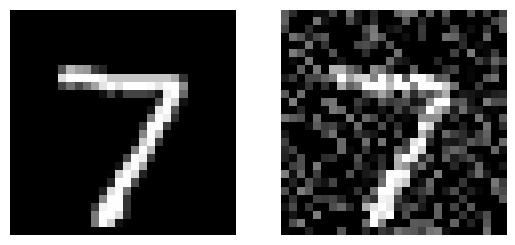

In [ ]:
# get first validation image
input = validation_set[0][0]

# generate noise image
noisy = noise(input)

# plot images
from matplotlib import pyplot
pyplot.rcParams['image.cmap'] = 'gray'

fig, ax = pyplot.subplots(1, 2)
ax[0].imshow(input.squeeze())
ax[0].axis("off")
ax[1].imshow(noisy.squeeze())
ax[1].axis("off")
pyplot.show()

## Auto-Encoder Network

The auto-encoder network is composed of two parts: the encoder that transforms the input image to a deep feature representation; and the decoder that produces an image from such a deep feature.

For the encoder $\mathcal E$, we will basically use the same convolutional network topology as in the last assignment.
An exception is that we perform our down-sampling via striding and not via pooling.
After each convolution, we apply the ReLU activation.
The output of the encoder is a $K=10$ dimensional deep feature representation.
The complete encoder network topology can be found below in Topology 1(a).

The decoder $\mathcal D$ performs the inverse operations of the encoder.
A fully-connected layer is used to increase the number of samples to the same size as the output of the flattening of the encoder.
Then, a ReLU activation is applied. 
The flattening needs to be undone next by reshaping the vector into the correct dimensionality.
A fractionally-strided convolutional layer increases the intermediate representation by a factor of 2.
Note that the fractionally-strided convolution is implemented in `torch.nn.ConvTranspose2d`, and the `stride` parameter should have the same value as for the encoder.
Additionally, the `torch.nn.ConvTranspose2d` has a parameter `output_padding` which needs to be adapted to reach the correct output shape (see Test 1).
After this layer, we perform another ReLU activation and another fractionally-strided convolution to arrive at the original input dimension.
The complete decoder network topology can be found below in Topology 1(b).

Finally, we combine the two sub-networks into one auto-encoder network.
While there exist several possibilities for doing this, we will implement a third `torch.nn.Module` that contains an instance of the encoder and an instance of the decoder.

Topology 1: Network configurations of the (a) encoder and (b) decoder networks

(a) Encoder Network

*   2D convolutional layer with $Q_1$ channels, kernel size $5\times5$, **stride 2** and padding 2
*   activation function ReLU
*   2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, **stride 2** and padding 2
*   flatten layer to convert the convolution output into a vector
*   activation function ReLU
*   fully-connected layer with the correct number of inputs and $K$ outputs

(b) Encoder Network

*   fully-connected layer with $K$ inputs and the correct number of outputs
*   activation function ReLU
*   reshaping to convert the vector into a convolution input
*   2D **fractionally-strided convolutional** layer with $Q_2$ channels, kernel size $5\times5$, stride 2 and padding 2
*   activation function ReLU
*   2D **fractionally-strided convolutional** layer with $Q_1$ channels, kernel size $5\times5$, stride 2 and padding 2

### Task 3: Encoder Network

Implement the encoder network for given parameters $Q_1$, $Q_2$, and $K$ as given in Topology 1(a).
Implement a network class that derives from `torch.nn.Module` and implement the `__init__` and the `forward` methods.

In [ ]:
class Encoder (torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    # call base class constrcutor
    super(Encoder,self).__init__()
      # define convolutional layers
    self.conv1 = torch.nn.Conv2d(1, Q1, kernel_size= [5,5], stride=2, padding=2)
    self.conv2 = torch.nn.Conv2d(Q1, Q2, kernel_size= [5,5], stride=2, padding=2)
    # pooling and activation functions will be re-used for the different stages
    self.act = torch.nn.ReLU()
    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    # ?? how do I know the size of the input to the first fully-connected layer?
    
    self.fc = torch.nn.Linear(Q2 * 7 * 7, K)


  def forward(self, x):
    # get the deep feature representation
        # compute first layer of convolution, pooling and activation
    a = self.act(self.conv1(x))
    # compute second layer of convolution, pooling and activation
    a = self.act(self.conv2(a))
    # get the deep features as the output of the first fully-connected layer
    # ?? why do I flatten before input to the first fully-connected layer?
    deep_feature = self.act(self.fc(self.flatten(a)))
    return deep_feature

### Task 4: Decoder Network

Implement the decoder network for given parameters $Q_1$, $Q_2$, and $K$ as given in Topology 1(b).
Implement a network class that derives from `torch.nn.Module` and implement the `__init__` and the `forward` methods.
The output of the decoder network is supposed to have values in the range $[0,1]$, similar to the input values.
We need to make sure that only these values can be achieved.
Think of possible ways of doing that, and apply the way that seems most reasonable.

In [ ]:
class Decoder (torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    # call base class constrcutor
    super(Decoder,self).__init__()
    # fully-connected layer
    self.fc = torch.nn.Linear(K, Q2 * 7 * 7)
    # convolutional layers
    self.deconv1 = torch.nn.ConvTranspose2d(Q2, Q1, kernel_size= [5,5], stride=2, padding=2, output_padding=1)
    self.deconv2 = torch.nn.ConvTranspose2d(Q1, 1, kernel_size= [5,5], stride=2, padding=2, output_padding=1)
    # activation function
    self.act = torch.nn.ReLU()
    # unflatten
    self.unflatten = torch.nn.Unflatten(dim=1, unflattened_size=(Q2,7,7))
      
  def forward(self, x):
    # reconstruct the output image
    a = self.unflatten(self.act(self.fc(x)))
    a = self.act(self.deconv1(a))
    a = self.deconv2(a)
    output = torch.sigmoid(a)
    return output

In [ ]:
import math
def output_dim(features_in, kernel_size, padding, stride, dilation = 1):
    """floor just returns rounded down to nearest int

    :param features_in: _description_
    :type features_in: _type_
    :param kernel_size: _description_
    :type kernel_size: _type_
    :param padding: _description_
    :type padding: _type_
    :param stride: _description_
    :type stride: _type_
    """
    return math.floor((features_in + 2 * padding - dilation * (kernel_size - 1) -1) / stride ) +1

### Task 5: Joint Auto-Encoder Network

Implement the auto-encoder network by combining the encoder and the decoder.
In the `__init__` function, instantiate an encoder from Task 3 and a decoder from Task 4.
In `forward`, pass the input through the encoder and the decoder: $\mathbf Y = \mathcal D(\mathcal E(\mathbf X))$

In [ ]:
class AutoEncoder(torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    super(AutoEncoder,self).__init__()
    self.encoder = Encoder(Q1, Q2, K)
    self.decoder = Decoder(Q1, Q2, K)

  def forward(self,x):
    # encode input
    deep_feature = self.encoder(x)
    # decode to output
    reconstructed = self.decoder(deep_feature)
    return reconstructed

### Test 1: Output Sizes

The code below instantiates the auto-encoder network with $Q_1 = Q_2 = 32$ and $K=10$. 
Then the given input $\mathbf X$ is provided to the (untrained) auto-encoder network.
Use this code to verify that the deep feature extracted by the encoder and the output from the decoder part both have the desired size. 
Also, we verify that the output values are between 0 and 1.

If the tests cannot be passed, please check the implementations in Task 3, 4, and 5.

In [ ]:
# run on cuda device?
device = torch.device("cuda")
# create network
network = AutoEncoder(32, 32, 10).to(device)

# create or select a sample
x = torch.randn((1,1,28,28))

# use encoder to encode image and check its size
deep_features = network.encoder(x.to(device))
assert deep_features.shape[1] == 10

# use decoder to generate an image and check its size and value range
output = network.decoder(deep_features)
assert output.shape[2:] == (28,28)
assert torch.all(output >= 0) and torch.all(output <= 1)

## Training and Evaluation
We will implement two training procedures, a simple auto-encoder network and a denoising auto-encoder network, which should be combined into one function.
To train the network, we will use the $L_2$ distance between the output and the input of the network as a loss function, which is implemented in `torch.nn.MSELoss`:

  $$\mathcal J^{L_2} (\mathbf X, \mathbf Y) = \|\mathbf X - \mathbf Y\|^2$$

For optimization, we will make use of the `Adam` optimizer with a learning rate of $\eta=0.001$.
We will run the training for 10 epochs and compute training and validation set loss after each epoch.

Denoising training requires generating noisy images before forwarding them into the network and taking the loss between output and the clean image.

For evaluation, we will check whether some of the validation set samples are correctly reconstructed from the auto-encoder network and whether the noise is removed from the denoising network.



### Task 6: Training Loop

For a given network and learning rate, implement a function that initiates loss function (`torch.nn.MSELoss`), optimizer, and trains the network for 10 epochs on the training data.
If parameter `denoise` is `True`, generate noisy batch with factor `alpha`.
Compute the running average of the training loss for each epoch.
At the end of each epoch, also compute the validation set loss.

In [ ]:
device = torch.device("cuda")

In [ ]:
def training_loop(network, lr=0.001, denoise=False, alpha=0.5):
  # define optimizer
  optimizer = torch.optim.Adam(network.parameters(), lr=lr)
  # define loss function
  loss = torch.nn.MSELoss()

  for epoch in range(10):
    # evaluate average loss for training and validation set
    train_loss = validation_loss = 0.

    for x,_ in train_loader:
      optimizer.zero_grad()

      # generate noise images by factor alpha as input if denoise is True
      if denoise:
        x = torch.tensor(noise(x, alpha), dtype=torch.float32)
      
      # compute network output
      y = network(x.to(device))

      # compute loss between output and input
      J = loss(y, x.to(device))
      # perform update
      J.backward()
      optimizer.step()
      # accumulate loss
      train_loss += J.item()


    # compute validation loss
    with torch.no_grad():
      for x,t in validation_loader:
        # generate noise images by factor alpha as input if denoise is True

        # compute network output
        y = network(x.to(device))
        # compute loss
        J = loss(y, x.to(device))
        # accumulate loss
        validation_loss += J.item()


    # print average loss for training and validation
    print(f"\rEpoch {epoch+1}; train: {train_loss/len(train_set):1.5f}, val: {validation_loss/len(validation_set):1.5f}")

### Task 7: Training of two Networks

Instantiate two `AutoEncoder` networks, one to train with only clean samples, and one to train with noisy images. Call the training loop for each network.

Note: If the training loss and validation loss do not decrease during training, try to reduce the learning rate (to $\eta=0.0005$ or even lower) and restart the training.
You will need to re-initialize the network, too.

In [ ]:
# define network
network1 = AutoEncoder(32, 32, 10).to(device)

# perform auto-encoder training 
training_loop(network1, lr=0.0005, denoise=False, alpha=0.5)

Epoch 1; train: 0.00144, val: 0.00112
Epoch 2; train: 0.00092, val: 0.00089
Epoch 3; train: 0.00084, val: 0.00084
Epoch 4; train: 0.00080, val: 0.00081
Epoch 5; train: 0.00077, val: 0.00078
Epoch 6; train: 0.00075, val: 0.00077
Epoch 7; train: 0.00074, val: 0.00075
Epoch 8; train: 0.00073, val: 0.00074
Epoch 9; train: 0.00072, val: 0.00073
Epoch 10; train: 0.00071, val: 0.00073


In [ ]:
# define network
network2 = AutoEncoder(32, 32, 10).to(device)

# perform auto-encoder training 
training_loop(network2, lr=0.0005, denoise=True, alpha=0.5)

/tmp/ipykernel_52293/1992853878.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(noise(x, alpha), dtype=torch.float32)


Epoch 1; train: 0.00199, val: 0.00167
Epoch 2; train: 0.00179, val: 0.00176
Epoch 3; train: 0.00171, val: 0.00170
Epoch 4; train: 0.00168, val: 0.00165
Epoch 5; train: 0.00165, val: 0.00161
Epoch 6; train: 0.00164, val: 0.00157
Epoch 7; train: 0.00163, val: 0.00155
Epoch 8; train: 0.00162, val: 0.00151
Epoch 9; train: 0.00161, val: 0.00150
Epoch 10; train: 0.00160, val: 0.00148


### Task 8: Reconstruction Result

This task is to visualize the reconstructed images from their originals.
For this purpose, select one image for each label from the first batch of the validation set. 
Generate the noisy input by Task 2.

Forward the clean images through the trained auto-encoder network to extract their reconstructions. 
Forward the noisy inputs through the trained denoising network to remove noise.

To show the difference, plot the original sample, reconstructed sample, noisy sample, and denoised sample for one label in one column. 
Make a single plot with 4 rows and 10 columns. 
See the reference plot in the slides.

/tmp/ipykernel_52293/976784709.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy = torch.tensor(noise(original), dtype=torch.float32).to(device)


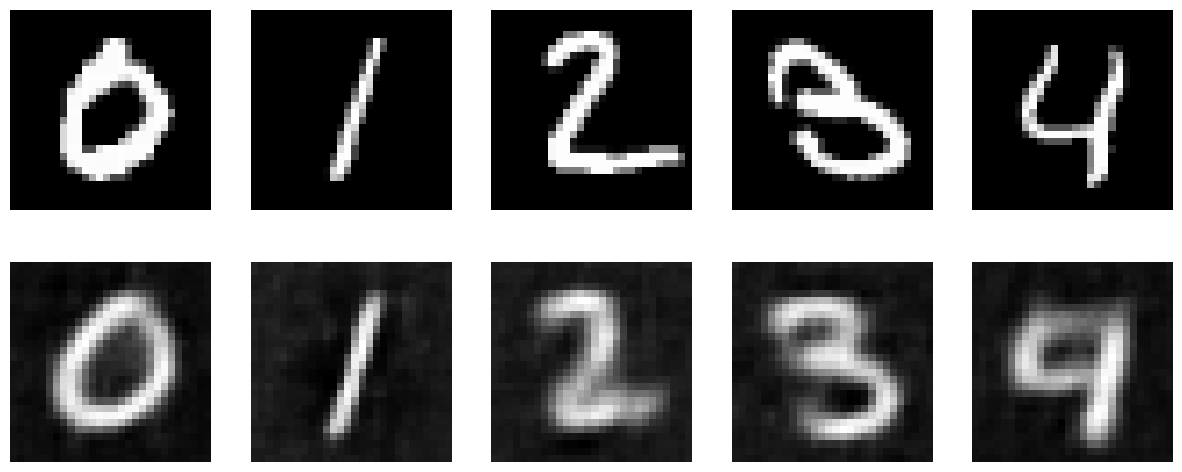

In [ ]:

validation_loader = torch.utils.data.DataLoader(dataset = validation_set, batch_size=128)

# get first validation set batch
x,t = next(iter(validation_loader))

# select first image of each class  
select = [ x[t==i][0] for i in range(10) ]


# If required, convert the list of select images into tensor through torch.stack
original = torch.stack(select)

# compute reconstructed samples
reconstructed = network1(original.to(device)).cpu().detach()  
# generate noisy samples
noisy = torch.tensor(noise(original), dtype=torch.float32).to(device)
# compute denoised samples
denoised = network1(noisy).cpu().detach()

samples = [original, reconstructed, noisy, denoised]

# plot images
from matplotlib import pyplot
pyplot.rcParams['image.cmap'] = 'gray'

fig, axes = pyplot.subplots(nrows=2, ncols = 5, figsize=(15, 6))

for i in range(2):
  for j in range(5):
    axes[i][j].imshow(samples[i][j].squeeze())
    axes[i][j].axis("off")

# Assignment 10: Learn to Write Like Shakespeare

In this assignment we will implement a simple recurrent network with one hidden layer.
We train this network on a medium-size poem "The Sonnet" written by William Shakespeare and use it for auto-completing sentences/phrases.

For training the network, we will need to transform the text into something machine-processable.
Basically, for each of the characters in the text, we provide a $D$-element one-hot encoding vector, where D is the total number of unique characters in the dataset.
Character sequences of length $S$ will, hence, be turned into matrices of size $\mathbf X = \{\vec x^{\{s\}}, 1 \leq s\leq S\} \in \mathbb R^{S\times D}$.
For each input, we provide the target values $\mathbf T$ of the same size, where the target for each sample is the next character: $\vec t^{\{s\}} = \vec x ^{\{s+1\}}$.

To speed up processing, these sequences will be put into batches, i.e., $\mathcal X, \mathcal T \in \mathbb R^{B\times S\times D}$.
This will automatically be achieved using the default PyTorch `DataLoader`.

The data that we will use is originally provided here: http://raw.githubusercontent.com/brunoklein99/deep-learning-notes/master/shakespeare.txt

## Data and Targets Preprocessing

First, we need to load the whole dataset $\vec c \in \mathbb R^N$, a vector of characters, and turn the data sequence into one-hot encodings.
For this purpose, we need to know the number $D$ of unique characters in our text.
For simplicity, we only consider lower-case characters and special symbols such as punctuation marks.
Also, the newline characters `'\n'` need to be handled -- you can also leave them inside and see what happens.

Then, for each of the characters, we need to assign a one-hot encoding, and build sequences of encodings.
For a given index $n$ into our data and a given sequence length $S$, we provide the input $\mathbf X ^{[n]}$ and the target $\mathbf T^{[n]}$ as follows:


  $$\mathbf X^{[n]} = \{\mathrm{enc}(n-S+s-1) | 1 \leq s \leq S\}$$
  $$\mathbf T^{[n]} = \{\mathrm{enc}(n-S+s) | 1 \leq s \leq S\}$$

where $\mathrm{enc}$ is a function that returns the one-hot encoding for the character at the specified location in the original dataset $\vec c$. 
In the case that the computation ($n-S+s-1$ or $n-S+s$) results in a negative value $\vec 0$ should be used instead. 

For example, for the original text `abcde`, sequence length $S=7$ and index $n=4$, we would have the representations for $x = $ `000abcd` and $t=$ `00abcde`.

Finally, we implement our own `Dataset` that returns the input and target encodings for any element of our input text.

### Download the data file

Please run the code block below to download the data file.

In [ ]:
import os
import random
import torch
import numpy as np

# download the data file
filename = "shakespeare.txt"
if not os.path.exists(filename):
  url = "http://raw.githubusercontent.com/brunoklein99/deep-learning-notes/master/"
  import urllib.request
  urllib.request.urlretrieve(url+filename, filename)
  print ("Downloaded datafile", filename)

### Set up of the device to run everything

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Task 1: Data Characteristics

Implement a function that:
1. Loads all text data from the poem file `shakespeare.txt`, iterates through and collect all the lowercase data that we want to learn from.
2. Create a list of unique characters contained in our data. This will allow us to obtain the dimension $D$.

Note:

* Here, we consider only lowercase characters to reduce the alphabet size. 
* Please make sure that you handle the newline character at the end of each line consistently.


In [ ]:
# load all data from the text file
def get_data(datafile='shakespeare.txt'):

    data = []

    # read/open the data file
    with open(datafile, 'r') as f:
        # read all lines
        lines = f.readlines()
        # iterate over all lines
        for line in lines:
            if len(line) == 0:
                continue
            # iterate over all characters in line
            for char in line:
                # perform other operations such as handling new lines, empty lines, uppercase characters ...
                if char == '\n' or char.isupper() or  (char.isalnum() == False and char not in '. '):
                    continue
                # append character to data list
                data.append(char)
    
    

    # create a list of unique characters contained in data.
    characters = list(set(data))
    
    
    return data, characters

In [ ]:
data, characters = get_data(datafile='shakespeare.txt')

D = len(characters)
print (f"Collected a total of {len(data)} elements of {D} unique characters")

Collected a total of 86509 elements of 28 unique characters


### Task 2: One-hot Encoding

Implement a dictionary that provides a unique one-hot encoding for each of the characters in the dataset. 
The dictionary takes as:

1. the key a character
2. its value is its one-hot vector representation of dimension $D$

Each of the characters need to be represented by a one-hot encoding.
Create a dictionary that provides the encoding for each unique character.

Note:

* You can use your own one-hot encoding procedure for the task.

In [ ]:
test = torch.zeros(D)
test[0] = 1
test

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
one_hot = dict()

for i, c in enumerate(characters):
  # create a unique one-hot vector for each character
  zero_encode = torch.zeros(D)
  zero_encode[i] = 1
  one_hot[c] = zero_encode

### Task 3: Sequence Coding

Write a function that provides the inputs and targets for a given sequence of the specified sequence length and index.
The last value of the target sequence should be the encoding of the character at the given index.
If a character is requested from outside the data range, prepend the inputs (and the targets) with 0.
Assure that $\vec t^{\{s\}} = \vec x^{\{s+1\}}$ $\forall s<S$.

In [ ]:
#We start off with the data, which is the list of all characters in the text-document. So the whole text.
#Then we choose a random index in the encoding and in the sequence part, we choose the sequence size that goes S value back from the index in the text.
#So basically, at every index the encoder encodes the index in the data into a one-hot vector
#(and if the index exceeds the range of the data, f.e. when the sequence goes over the borders, then 0 is added).
#The sequence function encodes S elements going back from the original index in the data and appends them in the input vector

def sequence(index, S):
  # collect both input and target encodings
  inputs, targets = [], []
  # go through the sequence and turn characters into encodings
  # start at index of the data and then go for S steps backwards
  index = index - 1
  for i in range(index, index-S, -1):
    # if we are at the beginning of the data, return a zero vector
    if i <= 0:
      inputs.append(torch.zeros(D))
    # otherwise, return the one-hot encoding of the character 
    else:
      inputs.append(one_hot[data[i]])
    if i+1 <= 0:
      targets.append(torch.zeros(D))
    else:
      # return the one-hot encoding of the target character
      targets.append(one_hot[data[i+1]])
  targets.reverse()
  inputs.reverse()
  return torch.stack(inputs), torch.stack(targets)

### Test 1: Sequences

Get a sequence for size 5 with index 2. This test assures that the data and target vectors are as desired, i.e., the first elements are 0 vectors, and later one-hot encoded data is added.

In [ ]:
# get sequence
x,t = sequence(2,5)

# check prepended zeros
assert torch.all(x[:4] == 0)
assert torch.all(t[:3] == 0)

# check one-hot encoded inputs and targets
assert torch.all(torch.sum(x[4:], axis=1) == 1)
assert torch.all(torch.sum(t[3:], axis=1) == 1)

We use the standard data loader with a batch size of $B=256$. Theoretically, each training sample could have its own sequence length $S$. To enable batch processing, the sequence size must be the same for each element in the batch (otherwise it cannot be transformed as one large tensor). Thus, our dataset needs to have a fixed sequence size $S$. An exact value for $S$ can be selected by yourself.

### Task 4: Dataset and Data Loader

Implement a `Dataset` class derived from `torch.utils.data.Dataset` that provides $\mathbf X^{[n]}$ and $\mathbf T^{[n]}$. Implement three functions:

1. The constructor `__init__(self, data, S)` that takes the dataset $\vec c$ and (initial) sequence length $S$.
2. The function `__len__(self)` that returns the number of samples in our dataset.
3. Finally the index function `__getitem__(self, index)` that returns the sequences $\mathbf X^{[n]}$ and $\mathbf T^{[n]}$ for a given `index`. The function from Task 3 can be used for this.

After implementing the `Dataset`, instantiate a `DatLoader` for the dataset with batch size of $B=256$.


In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, data, S):
    # prepare the data as required
    self.S = S
    self.data = data

  def __getitem__(self, index):
    # return input and target value for the given index
    return sequence(index, self.S)

  def __len__(self):
    # return the length of this dataset
    return len(self.data)

# instantiate dataset and data loader for a reasonable sequence length S
dataset = Dataset(data, S=10)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

### Test 2: Data Sizes

Here we check that the shape of the input and target from all batches are appropriate.

In [ ]:
for x,t in data_loader:
  dataset.S = random.choice(range(1,20))
  assert x.shape[2] == D
  assert x.shape == t.shape
  assert torch.all(x[:, 1:, :] == t[:, :-1, :])

## Elman Network Implementation

While there are implementations for recursive networks available in PyTorch, we here attempt our own implementation of the Elman network.
The input to our network is a batch of sequences of dimension $\mathcal X\in \mathbb R^{B\times S\times D}$.
Our network contains three fully-connected layers with dimensions $\mathbf W^{(1)} \in \mathbb R^{K\times D}$, $\mathbf W^{(r)} \in \mathbb R^{K\times K}$ and $\mathbf W^{2} \in \mathbb R^{D\times K}$ (plus bias neurons as handled by PyTorch).
The network processing will iterate through our sequence, and processes all elements in the batch simultaneously.
First, the hidden activation $\mathbf H^{\{0\}} \in \mathbb R^{B,K}$ is initialized with 0.
Then, we iterate over $1\leq s\leq S$ to process:

$\mathbf A^{\{s\}} = \mathbf W^{(1)} \mathbf X^{\{s\}} + \mathbf W^{(r)} \mathbf H^{\{s-1\}}$ $~~~~~~~~~$
$\mathbf H^{\{s\}}= g\bigl(\mathbf A^{\{s\}}\bigr)$ $~~~~~~~~~$ 
$\mathbf Z^{\{s\}} = \mathbf W^{(2)} \mathbf H^{\{s\}}$

where $g$ is the activation function, `PReLU` in our case, and $\mathbf X^{\{s\}}$ is the data matrix stored as $\mathcal X_{:,s,:}$. The final output of our network $\mathcal Z$ is a combination of all $\mathbf Z^{\{s\}}$ matrices in dimension as our input $\mathcal Z\in \mathbb R^{B\times S\times D}$.

For training, we need to compare the output $\mathcal Z$ of our network with our target batch $\mathcal T$. We will make use of the categorical cross-entropy loss as implemented in PyTorch's `torch.nn.CrossEntropyLoss`. In our case, we will implicitly compute:

$$\mathcal J^{CCE} = \frac1{SB} \sum\limits_{b=1}^B \sum\limits_{s=1}^S \sum\limits_{d=1}^D \mathcal T_{b,s,d} \log \mathcal Y_{b,s,d}$$

where $\mathcal Y_{b,s,d}$ is the result of SoftMax over the dimension $D$, which is the last index of our tensor.
As the documentation of `torch.nn.CrossEntropyLoss` states, the SoftMax is always computed across the `second` dimension of the data tensor (which would be $s$ in our case).
Hence, we need to make sure to reorder the dimensions of the tensors $\mathcal X$ and $\mathcal T$ such that the computation is correct.

### Task 5: Elman Network Implementation

Manually implement an Elman network derived from `torch.nn.Module` class using one fully-connected layer for hidden, recurrent and output units.

1. In the constructor, instantiate all required layers and activation functions for the given values of $D$ and $K$.
2. In the `forward` function, implement the processing of the input in the Elman network. Make sure that logit values are computed and returned for each element in the sequence. Try to use as much tensor processing as possible. Remember the shape of $\mathcal X$ is $B\times S\times D$, and when going through the sequence, we need to process $\vec x^{\{s\}}$ separately, while working on all batch elements simultaneously.


Note:

* You can also make use of `torch.nn.RNN` Pytorch module to build the recurrent layer and use a fully connected layer on top to implement the Elman network. However, using this module might not be easy.

In [ ]:
class ElmanNetwork(torch.nn.Module):
  def __init__(self, D, K):
    super(ElmanNetwork,self).__init__()
    self.W1 = torch.nn.Linear(D, K)
    self.Wr = torch.nn.Linear(K, K)
    self.W2 = torch.nn.Linear(K, D)
    self.activation = torch.nn.PReLU()

  def forward(self, x):
    # get the shape of the data
    B, S, D = x.shape
    # initialize the hidden vector in the desired size with 0
    # remember to put it on the device
    h_s = torch.zeros(B, self.Wr.in_features, device=device)
    # store all logits (we will need them in the loss function)
    Z = torch.empty(x.shape, device=device)
    # iterate over the sequence
    for s in range(S):
      # use current sequence item
      x_s = x[:,s,:]
      # compute recurrent activation
      a_s = self.W1(x_s) + self.Wr(h_s)
      # apply activation function
      h_s = self.activation(a_s)
      # compute logit values
      z = self.W2(h_s)
      # store logit value
      Z[:,s] = z
      
    # return logits for all sequence elements
    return Z

### Test 3: Network Output

We instantiate an Elman network with $K=1000$ hidden units.
We generate test samples in a given format, and forward them through the network and assure that the results are in the required dimensionality.

In [ ]:
network = ElmanNetwork(D, 1000).to(device)

with torch.no_grad():
  test_input = torch.empty(7, 25, D, device=device)
  test_output = network(test_input)
  assert test_input.shape == test_output.shape

### Task 6: Training Loop

To train the Elman network, we will use categorical cross-entropy loss, averaged over all samples in the sequence.
For each batch, we can optionally use a different sequence size -- while the size inside a batch must stay the same.

According to the PyTorch documentation, the `CrossEntropyLoss` handles logits and targets in shape $B\times O\times\ldots$.
In our case, logits and targets are in dimension $B\times S\times O$.
Hence, we need to make sure that we re-order the indexes such that we fulfil the requirement; you might want to use the `permute` or `transpose` operator.

Instantiate the optimizer with an appropriate learning rate $\eta$ and the loss function.
Implement the training loop for 20 epochs -- more epochs will further improve the results.
Compute the average training loss per epoch.

Note that 20 epochs will train for about 2 minutes, if implemented in an optimized way, on the GPU. Non-optimized training will take considerably longer.

WARNING: `CrossEntropyLoss` will not complain when the index order for the output $\mathcal Y$ and targets $\mathcal T$ is incorrect, just the results will be wrong.

In [ ]:
network = ElmanNetwork(D, 1000).to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
loss = torch.nn.CrossEntropyLoss()

for epoch in range(10):
  # create random sequence
  train_loss = 0.

  for x, t in data_loader:
    optimizer.zero_grad()
    # compute network output
    z = network(x.to(device))
    # compute loss, arrange order of logits and targets
    # use permute instead of T https://pytorch.org/docs/stable/generated/torch.permute.html
    J = loss(z.permute(0,2,1),t.permute(0,2,1))
    # compute gradient for this batch
    J.backward()
    optimizer.step()
    # compute average loss
    train_loss += J.item()
    #change up sequence size - not necessary!!!
    dataset.S = torch.randint(5,20,(1,))

  # print average loss for training and validation
  print(f"\rEpoch {epoch+1}; train loss: {train_loss/len(data_loader):1.5f}")

Epoch 1; train loss: 2.18184
Epoch 2; train loss: 1.78529
Epoch 3; train loss: 1.60531
Epoch 4; train loss: 1.47512
Epoch 5; train loss: 1.37475
Epoch 6; train loss: 1.30919
Epoch 7; train loss: 1.22565
Epoch 8; train loss: 1.16313
Epoch 9; train loss: 1.12787
Epoch 10; train loss: 1.09774


## Writing a Poem

With the trained network, we will turn it into a poet. 
Given some initial seed strings, we let the network predict the next character, which we append to our text. We repeat this process until we have produced a given string size.

For this purpose, we need to implement three functions. 
The first function needs to turn a given text into something that the network understands as input. 
The second function needs to interpret the network output, i.e., it needs to select a character from the predicted logits. 
There, we can implement two ways:
1. We take the character with the highest predicted class:
$$o^* = \argmax_o \vec y^{\{S\}}_o$$
2. We can also perform probability sampling, where each of the sample is drawn based on the probability that SoftMax provides -- such a function is for example implemented in `random.choices`.

Finally, we need to implement a function to iterstively call the encoding and prediction functions.

### Task 7: Text Encoding

For a given text (a sequence of $S$ characters), provide the encoding $\mathcal X \in R^{B\times S\times D}$.
Assure that the batch dimension for $B=1$ is added to the encoding, so that the network is able to handle it.

In [ ]:
def encode(text):
  text = text.lower()
  S = len(text)
  # dimension of encoding is 1, S, D
  encoding = torch.zeros((1,S,D))
  for i,c in enumerate(text):
    encoding[0][i] = one_hot[c]
  return encoding

### Task 8: Next Element Prediction

Write a function that predicts the next character of the sequence based on the logit values obtained from the network.
Implement both ways:
1. Using the maximum probability, i.e., selecting the character with the highest SoftMax probability $\max_o z^{\{S\}}_o$ and append this character to the `text`.
2. Using a probability sampling, i.e., we randomly draw a character based on the SoftMax probability distribution $\vec y^{\{S\}}$. `random.choices` provides the possibility to pass a list of characters and a list of probabilities.

Use the Boolean parameter `use_best` of your function to distinguish the two cases. 

Note:

* In our case, we are only interested in the logit for the last element of our sequences, i.e., $\vec z^{\{S\}}$.
* The logits are in dimension $\mathcal Z \in \mathbb R^{B\times S\times D}$ with $B=1$, and we are generally only interested in the prediction for the last sequence item.

In [ ]:
def predict(z, use_best=True):
  # select the appropriate logits
  z_S = z[0][-1]
  softmax = torch.nn.Softmax(dim=0)
  probs = softmax(z_S)
  if use_best:
    # take character with maximum probability
    best_index = torch.argmax(probs)
    next_char = characters[best_index]
  else:
    # sample character based on class probabilities
    next_char = np.random.choice(characters, p=probs.cpu().detach().numpy())
  return next_char

### Task 9: Sequence Completion


Write a function that takes a `seed` text which it will complete with the given number of characters.
Write a loop that turns the current `text` into an encoded sequence of its characters using the function from Task 7.
Forward the text through the network and take the prediction of the last sequence item $\vec z^{\{S\}}$ using the function from Task 8.
Append this to the current text (remember that Python strings are immutable).
Repeat this loop 80 times, and return the resulting `text`.

In [ ]:
def sequence_completion(seed, count, use_best):
  # we start with the given seed
  text = seed
  for i in range(count):
    # turn current text to one-hot batch
    x = encode(text)
    # predict the next character
    next_char = predict(network(x.to(device)), use_best)
    
    # append character to text
    text += next_char
    
  return text

### Task 10: Text Production

Select several seeds (such as `"thi", "ba", "wea", "tru", "sum", "q"`) and let the network predict the following 80 most probable characters, or using probability sampling.
Write the completed sentences to console.

In [ ]:
seeds = ["thi", "ba", "wea", "tru", "sum", "q"]

for seed in seeds:
  best = sequence_completion(seed, 100, use_best=True)
  # print seed and text
  print (f"\"{seed}\" -> \"{best}\"")
  sampled = sequence_completion(seed, 100, use_best=False)
  # print seed and text
  print (f"\"{seed}\" -> \"{sampled}\"")
  print()

"thi" -> "this thy proud tends not lovehy showhe soily and outward fairan make the lard af all they foul though t"
"thi" -> "this advantage though my love was butled injuty and thee.f the fairest as mineo shape so mone ham  or f"

"ba" -> "barren of leave how that fell arlest me blin that seems your being shall stay to my sid your seems you"
"ba" -> "back again assurednd the lessong youthhit be ut the trays upor the pleacheth.hat the truehin me or ate"

"wea" -> "wear that sorrow which  thought buried.ow many alves his do not so  love thee in suchest rehich shall b"
"wea" -> "weaknew nutle to the very windyh the  love theeve when thou from youthatt doth lived for criss.eret aud"

"tru" -> "truth upon me toomy deeds to crossjoin with thee that  do call my five weil to maker you survive when  "
"tru" -> "true needut you you patt sich urhan shamehy herved the fine immured she shall stay.hen though  brairend"

"sum" -> "summer and his wind where thou dost stayo sat uth of the summers flowe

# Assignment 11: Adversarial Training

In this assignment, we will show that adversarial training provides stability against adversarial attacks for the MNIST dataset.
We will compare three different types of training procedures:

1. Train with only the original samples
2. Train with original samples and added random noise
3. Train with original samples and adversarial samples generated by Fast Gradient Sign (FGS) method

Note that the results of this experiment might not translate well to other datasets.

## Dataset and Model

For our experiments, we come back to the dataset and the model that we have used before. 
Particularly, we train and test our methods on the MNIST dataset, using the same deep network structure as in previous exercises.

### Task 1: Dataset

Instantiate the training and validation set splits of MNIST, including data loaders. Select appropriate batch sizes for training and validation sets.

In [ ]:
import torch
import torchvision

# training set and data loader
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.ToTensor()), batch_size=64, shuffle=True)

# validation set and data loader
validation_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=False, download=True, transform=torchvision.transforms.ToTensor()), batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 9912422/9912422 [00:00<00:00, 184679160.13it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 107867937.51it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 99829545.11it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4601577.00it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Task 2: Classification Network

Use the same small-scale network as we have done in Assignment 8. 

Implement a network with two convolutional and two fully-connected layers.
Each convolution with kernel size $5\times5$ is followed by a $2\times2$ maximum pooling and a ReLU activation.
Select appropriate numbers of input and output channels for the convolutions.
The first fully-connected layer reduces the feature map to a certain size, which can be selected freely, while the second layer produces $O=10$ logits.

Note:

* You can also build your network with `torch.nn.Sequential`.

In [ ]:
class Network (torch.nn.Module):
  def __init__(self, Q1, Q2, K, O):
    # call base class constrcutor
    super(Network,self).__init__()
    # define convolutional layers
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size=(5,5), stride=1, padding=2)
    self.conv2 = torch.nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size=(5,5), stride=1, padding=2)
    # pooling and activation functions will be re-used for the different stages
    self.pool = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.act = torch.nn.ReLU()
    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(in_features=49*Q2, out_features=K)
    self.fc2 = torch.nn.Linear(in_features=K, out_features=O)

  
  def forward(self,x):
    return self.fc2(self.fc1(self.flatten(self.act(self.pool(self.conv2(self.act(self.pool(self.conv1(x)))))))))

## Image Manipulation

We implement two different ways to manipulate the images for generating additional training data.
The first way is to compute adversarial samples using the Fast Gradient Sign method.
Here, we want to adapt the image such that we maximize the loss between the network output and the target.
For this purpose, we need to compute the FGS adversarial samples by using the derivative of the loss with respect to the image:

$$\mathbf X_{\mathrm{FGS}} = \mathbf X + \alpha\cdot \mathrm{sign}(\nabla_{\mathbf X})$$

with

$$\nabla_{\mathbf X} = \frac{\partial \mathcal J^{\mathrm{CCE}}}{\partial \mathbf X} $$

As an optional task, we can implement the Fast Gradient Value method,

$$\mathbf X_{\mathrm{FGV}} = \mathbf X + \alpha\cdot\frac{\nabla_{\mathbf X}} {\mathrm{max} |\nabla_{\mathbf X}|}$$

and the generated adversarial samples will be used only in the validation, not training, to check that whether the network trained with FGS is also robust to FGV samples.

The second type of manipulation, similar to Assignment 9, is to add simple noise that represents the same type and magnitude of manipulations as FGS, i.e., we want our noisy image to be:

$$\mathbf X_{\mathrm{noise}} = \mathbf X + \alpha \{-1,1\}^{D\times E}$$ 

where $D$ and $E$ are the width and the height of the original image. $-1$ and $1$ are sampled with the same probability and independently for each pixel, e.g., using a Bernoulli distribution,.

In order to represent actual images, we will restrict the pixel values of both $\mathbf X_{\mathrm{FGS}}$ and $\mathbf X_{\mathrm{noise}}$ to be in the range $[0,1]$ by clipping any value that is outside that range.

### Task 3: Fast Gradient Sign

Implement a function that computes the gradient of the given loss function w.r.t. the input.
Compute the adversarial sample using the above definition of $\mathbf X_{\mathrm{FGS}}$, and restrict the output values to be in the range $[0,1]$.

Note that this function will be used with batches of samples.


In [ ]:
def FGS(x, t, network, loss, alpha=0.3):
  # tell autograd that we need the gradient for the input
  X = x.to(device)
  X.requires_grad_(True)
  # forward input
  z = network(X)
  # compute loss and gradient
  J = loss(z, t.to(device))
  J.backward()

  # get the gradient
  gradient = X.grad
  # create FGS adversarial sample
  adversarial_sample = torch.clamp(x + alpha*torch.sign(gradient), min=0, max=1)
  
  return adversarial_sample

### (Optional) Task 3a: Fast Gradient Value

Implement a function that computes the gradient of the given loss function w.r.t. the input.
Compute the adversarial sample using the above definition of $\mathbf X_{\mathrm{FGV}}$, and restrict the output values to be in the range $[0,1]$.

Note that this function will be used with batches of samples.

In [ ]:
def FGV(x, t, network, loss, alpha=0.6):
  # tell autograd that we need the gradient for the input
  X = x.to(device)
  X.requires_grad = True
  # forward input
  z = network(X)
  # compute loss and gradient
  J = loss(z, t.to(device))
  J.backward()

  # get the gradient
  gradient = x.grad
  # create FGV adversarial sample by dividing the gradient by the maximum gradient value
  adversarial_sample = x + alpha * gradient / gradient.abs().max()

  # restrict output to [0,1]
  adversarial_sample = torch.clamp(adversarial_sample, 0, 1)
  
  return adversarial_sample

### Task 4: Random Noise

Implement a function that computes the noisy sample according to the definition of $\mathbf X_{\mathrm{noise}}$ shown above, and restricts the output values to be in the range $[0,1]$.


Note that this function will also be used with batches of samples.

In [ ]:
import numpy as np

def noise(x, alpha=0.3):
  x = x.to(device)
  # generate noise
  N = torch.randint(low=0, high=1, size=x.shape, device=device)
  N[N==0] = -1
  # Add noise and clamp
  noisy_sample = torch.clamp(x+alpha*N, min=0, max=1)

  return noisy_sample

### Test 1: Adversarial Samples and Noisy Samples

Verify the generated $\mathbf X_{\mathrm{FGS}}$ (and $\mathbf X_{\mathrm{FGV}}$) and $\mathbf X_{\mathrm{noise}}$ have the same shape as $\mathbf X$ and all pixels are ranged in $[0,1]$.

Visualize $\mathbf X$, $\mathbf X_{\mathrm{FGS}}$, and $\mathbf X_{\mathrm{noise}}$.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# create network
network = Network(32,64,10,10).to(device)

loss = torch.nn.CrossEntropyLoss()

# use first validation batch
x, t = next(iter(validation_loader))

# Check the noisy samples: correct shape and range
x_noise = noise(x.to(device), alpha=0.3)
assert x_noise.shape == x.shape
assert torch.all(x_noise >= 0) and torch.all(x_noise <= 1)

# Check the generated adversarial samples: correct shape and range
x_fgs = FGS(x.to(device), t.to(device), network, loss, alpha=0.3)
assert x_fgs.shape == x.shape
assert torch.all(x_fgs >= 0) and torch.all(x_fgs <= 1)

In [ ]:
# if you implement FGV, then apply the same check for FGV as well
x_fgv = FGV(x.to(device), t.to(device), network, loss, alpha=1.2)
assert x_fgv.shape == x.shape
assert torch.all(x_fgv >= 0) and torch.all(x_fgv <= 1)

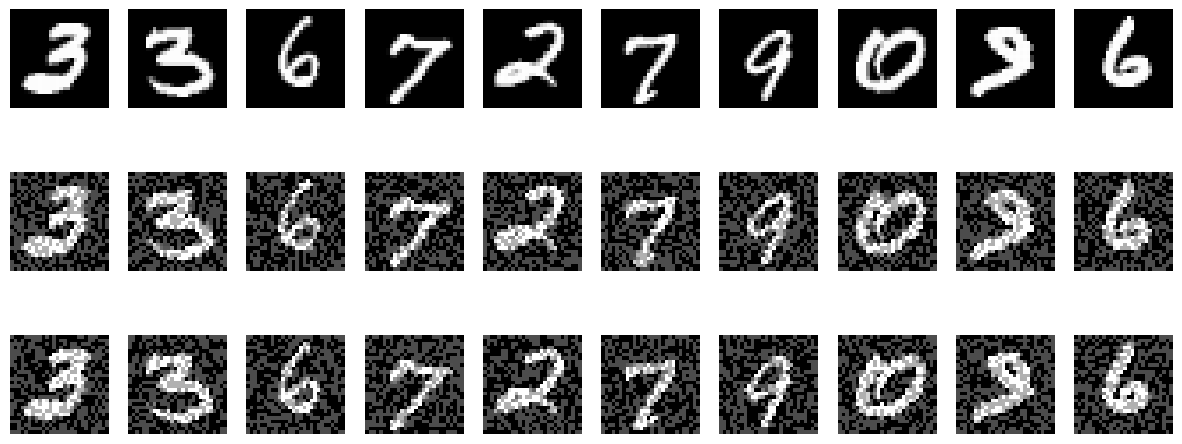

In [ ]:
samples = [x.cpu().detach().numpy(), x_fgs.cpu().detach().numpy(), x_noise.cpu().detach().numpy()]

# plot images
from matplotlib import pyplot
pyplot.rcParams['image.cmap'] = 'gray'

fig, axes = pyplot.subplots(nrows=3, ncols=10, figsize=(15, 6))

for i in range(3):
    for j in range(10):
      axes[i][j].imshow(samples[i][j].squeeze())
      axes[i][j].axis("off")

## Training and Evaluation

We will implement three different variations of the training procedure, which will be combined into one function.
In all three variations, we will iterate over all batches in the training set and train the network with standard categorical cross-entropy loss.
Variation 1 will only perform the **standard training**.
Variation 2 will generate **FGS adversarial samples** for all images in the batch, and perform an **additional weight update step** after training with the adversarial samples while assigning the original targets.
In variation 3, we will also train with additional data, but instead of generating adversarial samples, we will just **add noise to our images**.

For evaluation, we will compute two different measures.
First, we compute the **classification accuracy** of the network on the clean, unperturbed images of the validation set.
Additionally, we will create adversarial samples via our FGS (or FGV) technique for **all correctly classified validation set samples** and assess how many of these **adversarial samples are classified as their original class** by the network.

### Task 5: Training Loop

For a given network, loss and optimizer, implement a function that trains the network for one epoch on the training data.
If desired by the `add_additional_samples` parameter, implement variation 1, 2, or 3.
Perform update steps where they fit.


In [ ]:
def training_loop(network, loss, optimizer, add_additional_samples = None, alpha=0.3):
  for x,t in train_loader:
    optimizer.zero_grad()
    # compute output for current batch
    z = network(x.to(device))
    # compute loss
    J = loss(z, t.to(device))
    # compute gradient
    J.backward()
    # update parameters
    optimizer.step()

    if add_additional_samples is not None:
      # compute modified samples for batch
      if add_additional_samples == "FGS":
        # create FGS adversarial samples
        x_hat = FGS(x.to(device), t.to(device), network, loss, alpha=alpha)
      elif add_additional_samples == "FGV":
        # create FGS adversarial samples
        x_hat = FGV(x.to(device), t.to(device), network, loss, alpha=alpha)
      else:
        # create noisy samples
        x_hat = noise(x.to(device), alpha=alpha)

      optimizer.zero_grad()
      # compute output for modified samples
      z_hat = network(x_hat)
      # compute loss on modified samples
      J = loss(z_hat, t.to(device))
      # compute gradient
      J.backward()
      # update parameters
      optimizer.step()

### Task 6: Validation Loop


For a given network and loss function, iterate over the validation set and compute the classification accuracy on the original validation set samples.

For each batch, select the correctly classified images, and generate adversarial samples for these. 
The flag `FGV_sample` is to control which type of adversarial samples that should be generated here: FGS if `False`, FGV if `True`. 

Finally, compute how many of the adversarial samples are still classified as the original class by the network.

In [ ]:
def validation_loop(network, loss, alpha=0.3, FGV_sample=False):
  total, correct_clean_count, correct_adversarial_count = 0,0,0

  # iterate over validation set samples
  for x,t in validation_loader:
    with torch.no_grad():
      x = x.to(device)
      t = t.to(device)
      total += x.shape[0]
      # classify original samples
      z = network(x)
      p = torch.nn.functional.softmax(z, dim=1)

      # compute classification accuracy on original samples
      correct_clean_count += sum(torch.argmax(p, dim=1) == t).item()

    # select the correctly classified samples
    x_correct = x[torch.argmax(p, dim=1) == t].to(device)
    t_correct = t[torch.argmax(p,dim=1) == t].to(device)

    # create adversarial samples using FGS or FGV
    x_attack = FGS(x_correct, t_correct, network, loss, alpha) if not FGV_sample else FGV(x_correct, t_correct, network, loss, alpha)

    # check how many are correctly classified
    with torch.no_grad():
      # classify adversarial samples
      z_attack = network(x_attack)
      p_attack = torch.nn.functional.softmax(z_attack, dim=1)

      # compute classification accuracy on adversarial samples
      correct_adversarial_count += sum(torch.argmax(p_attack,dim=1)==t_correct)
      

  # compute clean and adversarial accuracy and return them
  clean_accuracy = correct_clean_count / total
  correct_adversarial_count = correct_adversarial_count.item()
  adversarial_accuracy = correct_adversarial_count / total / clean_accuracy
  print("Clean acc: ", clean_accuracy, " , Adv. acc: ", adversarial_accuracy)
  return clean_accuracy, adversarial_accuracy

### Task 7: Training of Three Networks

Instantiate three networks, one to train with only clean samples, one to additionally train with adversarial samples, and one to additionally train with noise.

Instantiate corresponding optimizers that train these networks. Make use of SGD with an appropriate learning rate $\eta$ and categorical cross-entropy loss.

Train each of the three networks for 10 epochs (or more) using their specific data extension.

Compute and store the validation set accuracy on the clean and adversarial samples -- note that adversarial samples will be generated for each network separately -- after each training epoch. 
Hence, the training time is extended as compared to normal training since the creation of adversarial samples requires time.


In [ ]:
# define one network for each training procedure
### network = Network(Q1=16, Q2=32, K= 20, O= 4).to(device) in exercise 8 but numer of logits = O = 10 in this exercise
networks = {"clean": Network(32,32,20,10).to(device), "FGS": Network(32,32,20,10).to(device), "noise": Network(32,32,20,10).to(device)}
# define optimizer
optimizer_clean = torch.optim.SGD(params=networks["clean"].parameters(),lr=0.005)
optimizer_FGS = torch.optim.SGD(params=networks["FGS"].parameters(),lr=0.005)
optimizer_noise = torch.optim.SGD(params=networks["noise"].parameters(),lr=0.005)

# define loss function
loss = torch.nn.CrossEntropyLoss()

# store accuracies on clean and adversarial samples for the three cases
clean_accuracies = {"clean": [], "FGS": [], "noise": []}
adversarial_accuracies = {"clean": [], "FGS": [], "noise": []}

# iterate over 10 epochs (or more)
for epoch in range(10):
  # perform training loop
  training_loop(networks["clean"], loss, optimizer_clean)
  training_loop(networks["FGS"], loss, optimizer_FGS, add_additional_samples="FGS")
  training_loop(networks["noise"], loss, optimizer_noise, add_additional_samples="noise")

  # compute and store validation set accuracies for each network
  clean_accuracy, adversarial_accuracy = validation_loop(networks["clean"], loss, FGV_sample=False)
  clean_accuracies["clean"].append(clean_accuracy)
  adversarial_accuracies["clean"].append(adversarial_accuracy)

  clean_accuracy, adversarial_accuracy = validation_loop(networks["FGS"], loss, FGV_sample=False)
  clean_accuracies["FGS"].append(clean_accuracy)
  adversarial_accuracies["FGS"].append(adversarial_accuracy)

  clean_accuracy, adversarial_accuracy = validation_loop(networks["noise"], loss, FGV_sample=False)
  clean_accuracies["noise"].append(clean_accuracy)
  adversarial_accuracies["noise"].append(adversarial_accuracy)

  print("Epoch: ", epoch)

Clean acc:  0.8885  , Adv. acc:  0.0029262802476083287
Clean acc:  0.9509  , Adv. acc:  0.347986118414134
Clean acc:  0.9145  , Adv. acc:  0.004592673592126845
Epoch:  0
Clean acc:  0.9212  , Adv. acc:  0.0007598784194528875
Clean acc:  0.9625  , Adv. acc:  0.41942857142857143
Clean acc:  0.9557  , Adv. acc:  0.0011509888040179973
Epoch:  1
Clean acc:  0.9349  , Adv. acc:  0.0003208899347523799
Clean acc:  0.9707  , Adv. acc:  0.5006696198619552
Clean acc:  0.9708  , Adv. acc:  0.005356407086938607
Epoch:  2
Clean acc:  0.948  , Adv. acc:  0.0005274261603375528
Clean acc:  0.9711  , Adv. acc:  0.5275460817629493
Clean acc:  0.9736  , Adv. acc:  0.011811832374691866
Epoch:  3
Clean acc:  0.9565  , Adv. acc:  0.0007318348144276006
Clean acc:  0.9742  , Adv. acc:  0.5673373024019709
Clean acc:  0.9756  , Adv. acc:  0.017732677326773267
Epoch:  4
Clean acc:  0.9638  , Adv. acc:  0.0008300477277443454
Clean acc:  0.9771  , Adv. acc:  0.6081260874014942
Clean acc:  0.9774  , Adv. acc:  0.031

### (Optional) Task 7a: Training of Three Networks and check the performance on FGV samples

Follow the exact same setup as Task 7.

Compute and store the validation set accuracy on the clean and FGV adversarial samples. Remember to set a higher $\alpha$ when generating FGV samples (at least $\times 2$ to the FGS $\alpha$).

In [ ]:
# define one network for each training procedure
networks_FGV = {"clean": Network(32,32,20,10).to(device), "FGV": Network(32,32,20,10).to(device), "noise": Network(32,32,20,10).to(device)}
# define optimizer
optimizer_clean = torch.optim.SGD(params=networks_FGV["clean"].parameters(),lr=0.005)
optimizer_FGV = torch.optim.SGD(params=networks_FGV["FGV"].parameters(),lr=0.005)
optimizer_noise = torch.optim.SGD(params=networks_FGV["noise"].parameters(),lr=0.005)

# define loss function
loss = torch.nn.CrossEntropyLoss()

# store accuracies on clean and adversarial samples for the three cases
clean_accuracies_FGV = {"clean": [], "FGV": [], "noise": []}
adversarial_accuracies_FGV = {"clean": [], "FGV": [], "noise": []}

# iterate over 10 epochs (or more)
for epoch in range(10):
  # perform training loop
  training_loop(networks_FGV["clean"], loss, optimizer_clean, alpha=0.6)
  training_loop(networks_FGV["FGV"], loss, optimizer_FGV, alpha=0.6, add_additional_samples="FGV")
  training_loop(networks_FGV["noise"], loss, optimizer_noise, alpha=0.6, add_additional_samples="noise")

  # compute and store validation set accuracies
  clean_accuracy, adversarial_accuracy = validation_loop(networks_FGV["clean"], loss, FGV_sample=True)
  clean_accuracies_FGV["clean"].append(clean_accuracy)
  adversarial_accuracies_FGV["clean"].append(adversarial_accuracy)

  clean_accuracy, adversarial_accuracy = validation_loop(networks_FGV["FGV"], loss, FGV_sample=True)
  clean_accuracies_FGV["FGV"].append(clean_accuracy)
  adversarial_accuracies_FGV["FGV"].append(adversarial_accuracy)

  clean_accuracy, adversarial_accuracy = validation_loop(networks_FGV["noise"], loss, FGV_sample=True)
  clean_accuracies_FGV["noise"].append(clean_accuracy)
  adversarial_accuracies_FGV["noise"].append(adversarial_accuracy)
  

Clean acc:  0.8652  , Adv. acc:  0.8112575127138234
Clean acc:  0.9196  , Adv. acc:  0.8800565463244889
Clean acc:  0.8943  , Adv. acc:  0.8875097841887509
Clean acc:  0.918  , Adv. acc:  0.8652505446623093
Clean acc:  0.9552  , Adv. acc:  0.9327889447236181
Clean acc:  0.9319  , Adv. acc:  0.9267088743427407
Clean acc:  0.9314  , Adv. acc:  0.8904874382649774
Clean acc:  0.972  , Adv. acc:  0.9493827160493827
Clean acc:  0.9465  , Adv. acc:  0.940095087163233
Clean acc:  0.9459  , Adv. acc:  0.9125700391161856
Clean acc:  0.9739  , Adv. acc:  0.9523565047746175
Clean acc:  0.9615  , Adv. acc:  0.9544461778471138
Clean acc:  0.9583  , Adv. acc:  0.9223625169571116
Clean acc:  0.9757  , Adv. acc:  0.9568514912370606
Clean acc:  0.9702  , Adv. acc:  0.9605236033807463
Clean acc:  0.963  , Adv. acc:  0.9333333333333335
Clean acc:  0.9807  , Adv. acc:  0.9591108391964923
Clean acc:  0.9736  , Adv. acc:  0.9652834839769926
Clean acc:  0.9678  , Adv. acc:  0.9391403182475718
Clean acc:  0.97

### Task 8: Plotting of Accuracies

Generate two plots.

In the first plot, compare the accuracies on the clean images of the validation set over the 10 epochs. (Plot clean accuracies)

In the second plot, compare the stability of the networks w.r.t. adversarial samples, i.e., how many adversarial samples can change the classification of the network. (Plot adversarial accuracies)

Exemplary plots can be found in the slides.


Text(0.5, 1.0, 'Adversarial accuracy')

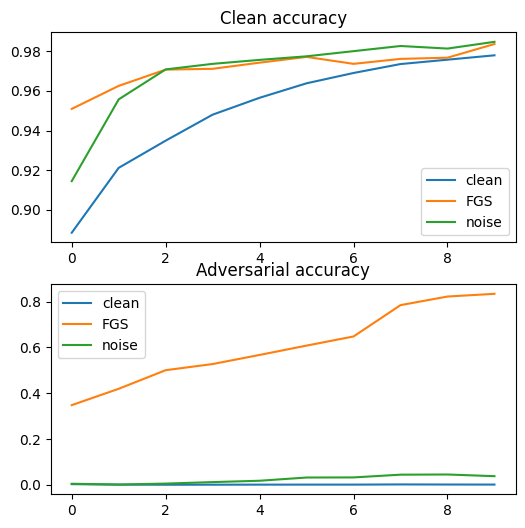

In [ ]:
from matplotlib import pyplot

pyplot.figure(figsize=(6,6))

# plot clean accuracies
pyplot.subplot(211)
pyplot.plot(clean_accuracies["clean"], label="clean")
pyplot.plot(clean_accuracies["FGS"], label="FGS")
pyplot.plot(clean_accuracies["noise"], label="noise")
pyplot.legend()
pyplot.title("Clean accuracy")


# plot adversarial accuracies
pyplot.subplot(212)
pyplot.plot(adversarial_accuracies["clean"], label="clean")
pyplot.plot(adversarial_accuracies["FGS"], label="FGS")
pyplot.plot(adversarial_accuracies["noise"], label="noise")
pyplot.legend()
pyplot.title("Adversarial accuracy")

### (Optional) Task 8a: Plotting of Accuracies

Follow the exact same setup as Task 8. This time, plot the validation accuracy on FGV samples instead.

Text(0.5, 1.0, 'Adversarial accuracy')

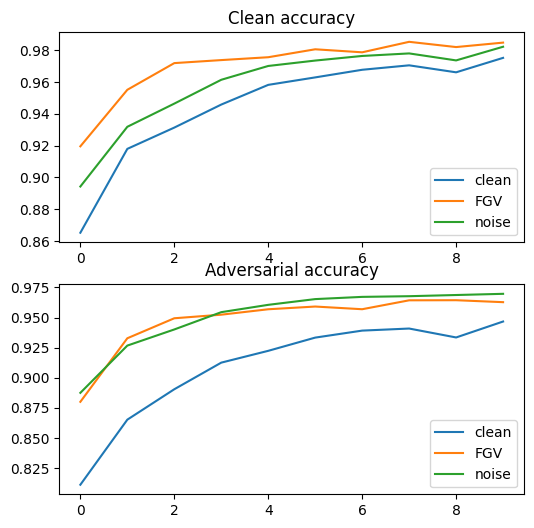

In [ ]:
from matplotlib import pyplot

pyplot.figure(figsize=(6,6))

# plot clean accuracies
pyplot.subplot(211)
pyplot.plot(clean_accuracies_FGV["clean"], label="clean")
pyplot.plot(clean_accuracies_FGV["FGV"], label="FGV")
pyplot.plot(clean_accuracies_FGV["noise"], label="noise")
pyplot.legend()
pyplot.title("Clean accuracy")

# plot adversarial accuracies
pyplot.subplot(212)
pyplot.plot(adversarial_accuracies_FGV["clean"], label="clean")
pyplot.plot(adversarial_accuracies_FGV["FGV"], label="FGV")
pyplot.plot(adversarial_accuracies_FGV["noise"], label="noise")
pyplot.legend()
pyplot.title("Adversarial accuracy")

# Assignment 12: Radial Basis Function Network

In this assignment, we show an alternative learning strategy that has been forgotten in the last few years but might get more popularity in the near future.
A radial basis function layer has some similarities with a fully-connected layer, but the outputs of the layer are not determined by a dot product between the weights and the input but rather by computing a distance.
Unfortunately, `PyTorch` does not provide us with an implementation of an RBF layer, so we need to implement our own.
Additionally, the activation function is replaced by a function that creates higher outputs for small absolute inputs, such as a Gaussian distribution:

$$a_r = ||\vec w_r - \vec x\|^2 $$ 
$$h_r = e^{-\frac{a_r^2}{2 \sigma_r^2}}$$


Finally, we want to combine the convolutional network with an RBF layer and a final fully-connected layer to compute the 10 outputs.
For simplicity, let us define $K$ as the input dimension of our RBF layer, $R$ as the number of basis functions (the number of outputs) of our RBF layer, and $O=10$ as the number of outputs (logits) of our network.
The complete network topology is given below.
We are both interested in the deep feature representation that is the output of the first fully-connected layer and in the logits that are output from the second fully-connected layer.

1. 2D convolutional layer with $Q_1$ channels, kernel size $5\times5$, stride 1 and padding 2
2. 2D maximum pooling layer with kernel size $2\times2$ and stride 2
3. Activation function ReLU
4. 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2
5. 2D maximum pooling layer with kernel size $2\times2$ and stride 2
6. Activation function ReLU
7. Flatten layer to convert the convolution output into a vector
8. Fully-connected layer with the correct number of inputs and $K$ outputs
9. RBF layer with $K$ inputs and $R$ outputs (implemented in Task 2)
10. RBF activation function (implemented in Task 3)
11. Fully-connected layer with $R$ inputs and $O$ outputs

## Dataset

We will train and test our methods on the MNIST dataset.

### Task 1: Dataset

We will make use of the default implementations of the MNIST dataset.
As usual, we will need the training and validation set splits of MNIST, including data loaders.
Select appropriate batch sizes for training and validation sets.

In [ ]:
import torch
import torchvision

# define transformation
transform = torchvision.transforms.ToTensor()

# training set and data loader
train_set = torchvision.datasets.MNIST("./data", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# validation set and data loader
validation_set = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100%|██████████| 9912422/9912422 [00:00<00:00, 109986035.37it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40231050.76it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26889994.23it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20707096.49it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Radial Basis Function

We will split our implementation into three different parts.
First, we implement the output $a_r$ as provided above.
Second, we implement the activation function $h_r$.
Finally, we build our network by inserting an RBF layer in between the fully-connected layers of our default network.

In order to implement the output $a_k$ of the RBF layer, we will use a weight matrix $\mathbf W\in \mathbb R^{R\times K} = \left[\vec w_1, \vec w_2,\ldots, \vec w_R \right]$ where each vector is of dimension $K$.
When handling batches $\mathbf X \in \mathbb R^{B\times K}$, we require to compute our activations as:

  $$\mathbf A \in \mathbb R^{B\times R} = (a_{n,r}) \qquad \text{with} \qquad a_{n,r} =  \bigl\|\vec w_r - \vec x^{[n]}\bigr\|^2 = \sum\limits_{k=1}^K \bigl\|w_{r,k} - \vec x_r^{[n]}\bigr\|^2$$

In order to speed up processing and enable the use of `tensor` operations, we need to bring $\mathbf W$ and $\mathbf X$ to the same size $\mathbb R^{B\times R\times K}$ by logically (**not physically!**) copying the data and the weights to $\mathcal W$ and $\mathcal X$.
Then, the resulting $ \mathcal A = || \mathcal W - \mathcal X||$ needs to be summed up over dimension $K$ to arrive at $\mathbf A$ as given above.


### Task 2: Radial Basis Function Layer

Implement the RBF layer in PyTorch that computes the activation $\mathbf A$ of a radial basis function. Derive your layer from `torch.nn.Module`.
In the `__init__` function, instantiate the weight matrix $\mathbf W$ as a `torch.nn.Parameter`, and initialize the weight values randomly from values in range $[-2,2]$.
In `forward`, compute and return the activation from the stored weight matrix and the given input batch as indicated above.


In [ ]:
class RBFLayer(torch.nn.Module):
  def __init__(self, K, R):
    # call base class constructor
    super(RBFLayer, self).__init__()
    # store a parameter for the basis functions
    # initialize the matrix between -2 and 2
    self.W = torch.nn.Parameter(torch.rand(R, K) * 4 - 2)
    


  def forward(self, x):
    # collect the required shape parameters, B, R, K
    B, R, K = x.shape[0], self.W.shape[0], self.W.shape[1]
    # Bring the weight matrix of shape R,K to size B,R,K by adding batch dimension (B, dim 0)
    W = self.W.unsqueeze(0).expand(B, R, K)
    # Bring the input matrix of shape B,K to size B,R,K by adding R dimension (dim=1)
    X = x.unsqueeze(1).expand(B, R, K)
    # compute the activation 
    A = torch.sum((W - X)**2, dim=2)
    return A

### Task 3: Radial Basis Function Activation

The activation function also requires a `Parameter`, i.e., the standard deviations of the Gaussian.
Hence, we need to implement the activation function also as a `torch.nn.Module`.
Here, we are treating the denominator of the Gaussian as a separate variable: `sigma2 = 2*sigma*sigma`.

Implement the activation function with learnable `sigma2` parameters.
Initialize all `sigma` parameters with the value of 1.




In [ ]:
class RBFActivation(torch.nn.Module):
  def __init__(self, R):
    # call base class constructor
    super(RBFActivation, self).__init__()
    # store a parameter for the basis functions
    # initialize all sigma to 1
    sigma = torch.ones(R)
    self.sigma2 = torch.nn.Parameter(2*sigma*sigma)
  def forward(self, x):
    # implement the RBF activation function
    output = torch.exp(-x/self.sigma2)
    return output

### Test 1: RBF Layer and Activation

We instantiate an RBF layer and an RBF activation function for $K=4$ and $R=12$ and generate a random batch of size $B=16$.
We call both the RBF layer and the activation on the batch, and make sure that the resulting output is of shape $B\times R$.
This test also assures that the layers above are functioning and do not raise exceptions.

In [ ]:
# instantiate layer and activation
test_RBF_layer = RBFLayer(K=4, R=12)
test_RBF_activation = RBFActivation(R=12)

# create test data batch
test_data = torch.empty((16,4))

# forward test data through the layer and the activation
a = test_RBF_layer(test_data)
h = test_RBF_activation(a)

# check that the shape is correct
assert h.shape == (16,12)

### Task 4: Radial Basis Function Network

As the network, we rely on our convolutional network from Assignment 8.
However, this time we add an RBF layer and its activation between the first and the second fully-connected layer.
We will return both the deep features of dimension $K$ and the logits of dimension $O$ in `forward`, which we will use later for visualization purposes.
Note that the processing will happen on batch level.




In [ ]:
class RBFNetwork(torch.nn.Module):
  def __init__(self, Q1, Q2, K, R, O):
    # call base class constrcutor
    super(RBFNetwork,self).__init__()
    # define convolutional layers
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size=(5,5), stride=1, padding=2)
    self.conv2 = torch.nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size=(5,5), stride=1, padding=2)
    # pooling and activation functions will be re-used for the different stages
    self.pool = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.act = torch.nn.ReLU()
    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(in_features=49*Q2, out_features=K)
    # define RBF layer and its activation
    self.rbf_layer = RBFLayer(K=K, R=R)
    self.rbf_activation = RBFActivation(R=R)
    # define second fully-connected layer
    self.fc2 = torch.nn.Linear(in_features=R, out_features=O)
  
  def forward(self,x):
    # get the deep feature layer as the output of the first fully-connected layer
    deep_feature = self.fc1(self.flatten(self.act(self.pool(self.conv2(self.act(self.pool(self.conv1(x))))))))
    # apply the RBF layer and activation
    a = self.rbf_activation(self.rbf_layer(deep_feature))
    # apply the last fully-connected layer to obtain the logits
    logits = self.fc2(a)
    # return both the logits and the deep features
    return logits, deep_feature


### Task 5: Training and Validation Loop

The training and validation loops are as usual.
Instantiate the network with $Q_1=64$, $Q_2=32$, $K=2$, $R=100$ and $O=10$.
Instantiate loss function and optimizer.
Train the network on the training set.
Compute the validation set accuracy after each epoch of training.

Hints: 

* The validation set accuracy after the first epoch should be more than 80%. If it is much lower, increase the learning rate and/or change the optimizer.
* On the other hand, if the accuracy gets stuck around 10% and does not change over the epochs, reduce the learning rate.
* The training on the GPU might take several minutes. On the CPU, training times might be increased.

In [ ]:
def training_loop(network):
  optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
  loss = torch.nn.CrossEntropyLoss()

  for epoch in range(20):
    accuracy_train = 0
    for x,t in train_loader:
      x = x.to(device)
      t = t.to(device)
      
      # train network with the current batch
      optimizer.zero_grad()
      # network returns logits (z) and deep feature, that's why we need two variables here 
      y, _ = network(x)
      J = loss(y,t)
      J.backward()
      optimizer.step()

      # compute training set accuracy
      accuracy_train += torch.sum(torch.argmax(y, dim=1) == t).item()
      
    # compute validation set accuracy
    accuracy_valid = 0
    with torch.no_grad():
      for x,t in validation_loader:
        x = x.to(device)
        t = t.to(device)
        y, _ = network(x)
        accuracy_valid += torch.sum(torch.argmax(y, dim=1) == t).item()

    print(F"Epoch {epoch+1}: train accuracy: {accuracy_train/len(train_set):1.4f} test accuracy: {accuracy_valid/len(validation_set):1.4f}")

In [ ]:
# instantiate RBFnetwork and train model
network = RBFNetwork(Q1=64, Q2=32, K=2, R=100, O=10).to(device)
training_loop(network)

Epoch 1: train accuracy: 0.8383 test accuracy: 0.9319
Epoch 2: train accuracy: 0.9435 test accuracy: 0.9528
Epoch 3: train accuracy: 0.9567 test accuracy: 0.9606
Epoch 4: train accuracy: 0.9637 test accuracy: 0.9613
Epoch 5: train accuracy: 0.9707 test accuracy: 0.9626
Epoch 6: train accuracy: 0.9747 test accuracy: 0.9616
Epoch 7: train accuracy: 0.9776 test accuracy: 0.9621
Epoch 8: train accuracy: 0.9801 test accuracy: 0.9616
Epoch 9: train accuracy: 0.9838 test accuracy: 0.9641
Epoch 10: train accuracy: 0.9848 test accuracy: 0.9634
Epoch 11: train accuracy: 0.9864 test accuracy: 0.9606
Epoch 12: train accuracy: 0.9875 test accuracy: 0.9610
Epoch 13: train accuracy: 0.9886 test accuracy: 0.9619
Epoch 14: train accuracy: 0.9900 test accuracy: 0.9636
Epoch 15: train accuracy: 0.9897 test accuracy: 0.9617
Epoch 16: train accuracy: 0.9903 test accuracy: 0.9649
Epoch 17: train accuracy: 0.9915 test accuracy: 0.9626
Epoch 18: train accuracy: 0.9923 test accuracy: 0.9627
Epoch 19: train acc

### (Optional) Task 5a: 

Consider the minimum number for $R$, and use this number to train the model.

In [ ]:
# instantiate RBFnetwork and train model with minimum number of R
### maybe 10 because of O = 10?
network_minimal = RBFNetwork(Q1=64, Q2=32, K=2, R=10, O=10).to(device)
training_loop(network_minimal)

Epoch 1: train accuracy: 0.4714 test accuracy: 0.6221
Epoch 2: train accuracy: 0.6988 test accuracy: 0.7530
Epoch 3: train accuracy: 0.7763 test accuracy: 0.8011
Epoch 4: train accuracy: 0.8341 test accuracy: 0.8412
Epoch 5: train accuracy: 0.8752 test accuracy: 0.8724
Epoch 6: train accuracy: 0.8928 test accuracy: 0.8865
Epoch 7: train accuracy: 0.9323 test accuracy: 0.9479
Epoch 8: train accuracy: 0.9666 test accuracy: 0.9568
Epoch 9: train accuracy: 0.9749 test accuracy: 0.9560
Epoch 10: train accuracy: 0.9783 test accuracy: 0.9596
Epoch 11: train accuracy: 0.9822 test accuracy: 0.9612
Epoch 12: train accuracy: 0.9842 test accuracy: 0.9571
Epoch 13: train accuracy: 0.9869 test accuracy: 0.9579
Epoch 14: train accuracy: 0.9872 test accuracy: 0.9617
Epoch 15: train accuracy: 0.9906 test accuracy: 0.9600
Epoch 16: train accuracy: 0.9909 test accuracy: 0.9556
Epoch 17: train accuracy: 0.9910 test accuracy: 0.9602
Epoch 18: train accuracy: 0.9932 test accuracy: 0.9612
Epoch 19: train acc

## Visualization
We have selected the dimensionality of the deep features to be $K=2$ in order to be able to visualize them.
The goal is to extract the deep feature representations of all validation samples.
For each sample, we regard the 2D representation as a point in a 2D space, which we can mark with a color that is dependent on the label of that sample.
After plotting a dot for each of the validation samples, we can observe if we find some structure in the feature space.

Finally, also the learned basis functions $\vec w_r$ can be plotted, including their according to size $\sigma_r$.
This allows us to see whether the RBF network has adapted itself to the data.

### Task 6: Deep Feature Extraction

Iterate through the validation set samples and extract the 2D deep feature representations for the images.
Store the results in 10 different lists, one for each target class.

In [ ]:
def get_features(network):
  # extract all deep features for all validation set samples
  features = [[] for _ in range(10)]

  with torch.no_grad():
    for x,t in validation_loader:
      x = x.to(device)
      t = t.to(device)
      # extract deep features
      ### as above: network outpus logits (z) and deep features
      _, deep_features = network(x)
      # separate the 10 different targets into separate lists
      for i, targ in enumerate(t):
        features[targ].append(deep_features[i])

  # convert features to 2D for later processing/plotting
  features = [torch.stack(f) for f in features]
  return features


In [ ]:
# call the function to get the deep features
features = get_features(network)

### (Optional) Task 6a: Deep Feature Extraction for `network_minimal`
Follow the exact same setup as Task 6. 

In [ ]:
# get the deep features from the network_minimal
features_minimal = get_features(network_minimal)

### Task 7: Deep Feature Visualization & Task 8: Basis Function Visualization

We provide a list of 10 different colors, one for each digit class.
For each of the 10 digits, plot all the samples in a 2D plot in the according color as a dot, maybe using `pyplot.scatter`. 

Obtain the basis functions that were learned during network training from the layer implemented in Task 2.
Obtain the scaling factor $\sigma_r$ for each of the basis functions that were learned by the activation function layer from Task 3.
For each of the basis functions $\vec w_r$, draw a black circle with a radius corresponding to `sigmas`, which is computed from `sigma2` as follows:
$$\mathrm{sigmas} = \sqrt\frac{\mathrm{sigma2}}{2}$$
Overlay the plot from Task 7 with these circles.

Notes:

* The `s=` parameter to the `scatter` function is given in pts, so you might need to scale those values to be visible.
* Since each notebook cell uses its own drawing process, we need to combine Tasks 7 and 8 here.
* An example for $R=100$ can be found from exercise -- obtaining the shown legend is more difficult and does not need to be replicated.

In [ ]:
import numpy
from matplotlib import pyplot
from matplotlib.patches import Patch

def plot(features, network):
  # define 10 visually distinct colors
  colors = numpy.array([
      [230, 25, 75],
      [60, 180, 75],
      [255, 225, 25],
      [67, 99, 216],
      [245, 130, 49],
      [145, 30, 180],
      [70, 240, 240],
      [240, 50, 230],
      [188, 246, 12],
      [250, 190, 190],
  ]) / 255.


  # generate 10 scatter plots, one for each label
  for i in range(10):
    pyplot.scatter(features[i][:,0].to("cpu").detach().numpy(),features[i][:,1].to("cpu").detach().numpy(),s=1,color=colors[i],label=F'{i}')

  # get the basis functions from the rbf layer
  basis_functions = network.rbf_layer.W.to("cpu").detach().numpy()
  # get the basis functions from the rbf activation
  sigmas = network.rbf_activation.sigma2.to("cpu").detach().numpy()

  # plot learned centers
  pyplot.scatter(basis_functions[:,0], basis_functions[:,1], color="k", marker="o", s=sigmas*100, facecolors="none", label="BF")

  # make the plot more beautiful
  pyplot.legend()


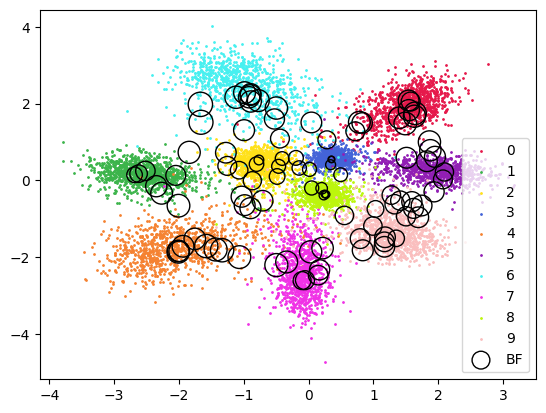

In [ ]:
# call plot function and plot the result
plot(features, network)

### (Optional) Task 7a: Deep Feature Visualization & Task 8: Basis Function Visualization for another network

Follow the exact same setup as Task 7. This time, plot results for `network_minimal`.

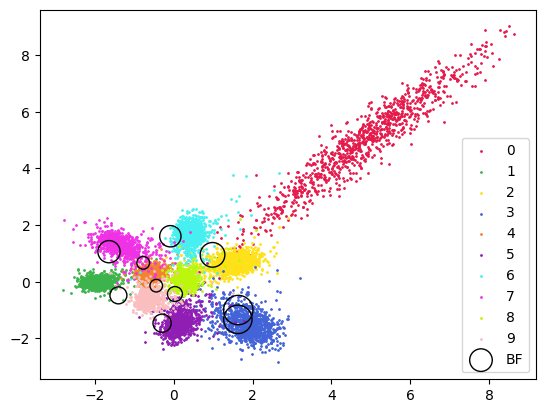

In [ ]:
# instantiate plot function and plot the result
plot(features_minimal, network_minimal)